In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import csv
import optuna

import gymnasium as gym
from gymnasium import spaces

from stable_baselines3.common.callbacks import BaseCallback, EvalCallback
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.monitor import Monitor

from sb3_contrib import MaskablePPO
from sb3_contrib.common.maskable.utils import is_masking_supported
from sb3_contrib.common.wrappers import ActionMasker


C:\Users\pelay\miniforge3\envs\DeepRL\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# **Carga de los datasets**

En esta parte se cargan los datasets necesarios para definir el environment del problema de acuicultura. Estos datasets son los relativos a la **temperatura**, **precios de venta de peces** distinguiendo por tres tipos de tamaños, **coste de los alimentos** y la **tabla de tasas de crecimiento, alimentación y mortalidad** en función de la temperatura y el tamaño del pez.

En este caso los datasets de temperaturas, precios de los peces y coste de los alimentos contienen muestras de 7 años (i.e. 364 semanas).

Temperaturas:
[[ 1.   15.54]
 [ 2.   15.38]
 [ 3.   14.88]
 [ 4.   14.57]
 [ 5.   14.36]]
(364, 2)

Precios:
[[1.   4.25 4.76 7.22]
 [2.   4.26 4.77 7.07]
 [3.   4.02 4.35 6.96]
 [4.   4.06 4.16 7.06]
 [5.   4.02 4.12 6.99]]
(364, 4)

Tasas de alimento (ID=121):
[['121' 11 13 30 48 0.5 0.08 0.022029]
 ['121' 13 15 30 48 0.8 0.24 0.02098]
 ['121' 15 17 30 48 1.5 0.76 0.0199809]
 ['121' 17 19 30 48 1.7 1.03 0.0190295]
 ['121' 19 21 30 48 1.9 1.38 0.0181233]]
(154, 8)

Precios de alimento:
[[53.       1.12998]
 [54.       1.12998]
 [55.       1.12998]
 [56.       1.12998]
 [57.       1.12998]]
(364, 2)


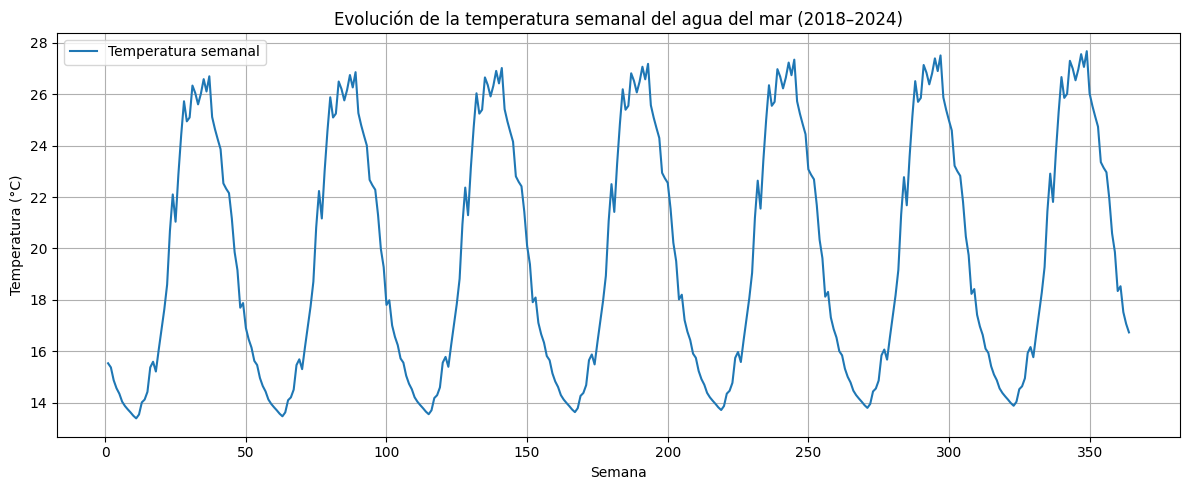

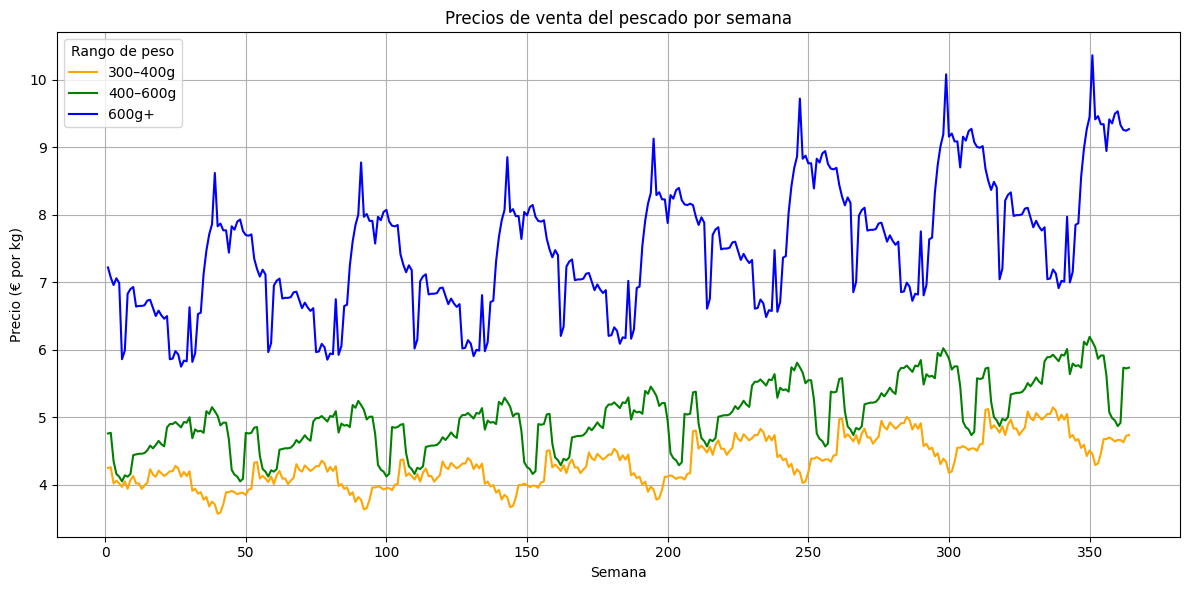

In [2]:
# 1. Se cargan los datasets.
df_temp = pd.read_csv("temperatures.csv")  # Dataset de temperaturas.
df_sale_prices = pd.read_csv("sale_prices.csv")  # Dataset de precios de venta.
df_feed_rates = pd.read_csv("feed_rates.csv")  # Dataset de de las distintas tasas de los alimentos.
df_feed_prices = pd.read_csv("feed_prices.csv")  # Dataset de precios del alimento.

# 2. Se limpia y convierte el dataset de tasas de alimentos antes de pasar a array.
df_feed_rates['id'] = df_feed_rates['id'].astype(str).str.strip()

# 3. Se convierten los datasets a arrays numpy.
temperature = df_temp[['Week', 'TEMPERATURE']].to_numpy()
sale_prices = df_sale_prices.to_numpy()
feed_rates = df_feed_rates.to_numpy()
feed_prices = df_feed_prices.to_numpy()

# 4. Se asegura que las columnas tengan los tipos correctos.
temperature[:, 0] = temperature[:, 0].astype(int)
sale_prices[:, 0] = sale_prices[:, 0].astype(int)
feed_prices[:, 0] = feed_prices[:, 0].astype(int)

# 5. Se filtran las tasas para un tipo de alimento a modo de ejemplo.
chosen_feed_rates = feed_rates[feed_rates[:, 0] == '121']

# 6. Se muestran los tamaños y ejemplos de los datasets.
print("Temperaturas:")
print(temperature[:5])
print(temperature.shape)

print("\nPrecios:")
print(sale_prices[:5])
print(sale_prices.shape)

print("\nTasas de alimento (ID=121):")
print(chosen_feed_rates[:5])
print(chosen_feed_rates.shape)

print("\nPrecios de alimento:")
print(feed_prices[52:57])
print(feed_prices.shape)

# 7. Se hace un gráfico de evolución de temperaturas del agua del mar.
plt.figure(figsize=(12, 5))
plt.plot(temperature[:, 0], temperature[:, 1], label="Temperatura semanal")
plt.title("Evolución de la temperatura semanal del agua del mar (2018–2024)")
plt.xlabel("Semana")
plt.ylabel("Temperatura (°C)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# 8. Se hace un gráfico de precios de pescado por rango de peso.
weeks = sale_prices[:, 0]
precios_300_400 = sale_prices[:, 1]
precios_400_600 = sale_prices[:, 2]
precios_600_plus = sale_prices[:, 3]

plt.figure(figsize=(12, 6))
plt.plot(weeks, precios_300_400, label='300–400g', color='orange')
plt.plot(weeks, precios_400_600, label='400–600g', color='green')
plt.plot(weeks, precios_600_plus, label='600g+', color='blue')

plt.title("Precios de venta del pescado por semana")
plt.xlabel("Semana")
plt.ylabel("Precio (€ por kg)")
plt.grid(True)
plt.legend(title="Rango de peso")
plt.tight_layout()
plt.show()



# **Definición del environment de acuicultura**

En este caso esta clase contiene los siguientes métodos:

*   Método `__init__` donde se inicializan las principales variables del entorno
de acuicultura relativas a los datasets y otras más utilizadas.

*   Método `reset` para reiniciar el entorno de acuicultura cada vez que se inicia un nuevo episodio.

*   Método `step` para avanzar un paso en cada episodio en función de la acción tomada. Este método devuelve entre otras cosas el nuevo estado (u observación) obtenido junto a su máscara, la recompensa y el criterio de parada.

*   Método `action_masks` que genera una lista booleana indicando qué acciones están permitidas en el estado actual, en función de las semanas restantes y las restricciones mínimas de siembra. Este método es útil para evitar que el agente elija acciones no válidas.

*   Método `_get_observation` donde se devuelve la observación actual que describe el estado en el que se encuentra el problema.

*   Método `_calc_12month_prices` que calcula el array plano de 36 precios proyectados por mes (12 meses · 3 tipos de precios) de los últimos 12 meses de los 18 máximos de siembra disponibles. Esta variable se utiliza como parte del conjunto de observaciones que se introduce en la red neuronal de la política del agente. 

*   Método `_simulate_growth_helper` que simula el proceso de crecimiento de los peces en función de la semana en que se comienza la siembra y el número de semanas de siembra escogidas por la acción tomada por el agente. Este método devuelve algunos valores como el número de peces, su tamaño final y cantidad de alimento utilizado, necesarios para calcular el beneficio obtenido.

*   Método `_compute_reward` que calcula el beneficio obtenido en función de los valores obtenidos tras el proceso de simulación de crecimiento de los peces. En este caso este beneficio se utiliza como recompensa en cada paso del episodio.

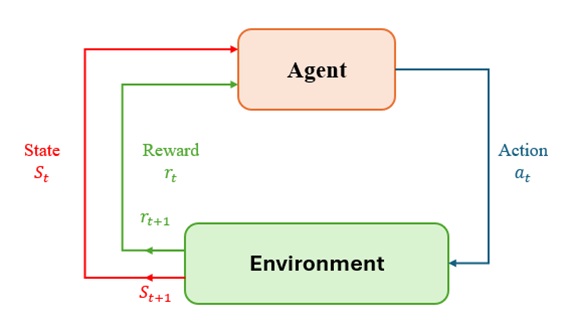

In [7]:
class AcuiculturaEnvDiscreto(gym.Env):
    def __init__(self, temperature_data, feed_rates_data, sale_prices_data, feed_prices_data, max_weeks=None, start_local_week=None, max_seeding=78, initial_fish_weight=30, initial_population=7100, chosen_feed_id='121'):

        # ---------------------------------------
        # 0. LLAMADA A CONSTRUCTOR DE GYM
        # ---------------------------------------
        # La función super().__init__() invoca el constructor de la clase base (gym.Env),
        # asegurando que todas las funcionalidades internas de Gym queden correctamente inicializadas.
        # Es obligatorio hacerlo para que el entorno sea compatible con los algoritmos de SB3.
        super().__init__()

        # ----------------------------------
        # 1. CARGA DE DATOS EXTERNOS
        # ----------------------------------

        # Se insertan las series temporales necesarias para el entorno.
        self.temperature_data = temperature_data  # Datos semanales de temperatura ambiental (semanas 1 a 364).
        self.feed_rates_data = feed_rates_data  # Tabla técnica con tasas de alimentación, crecimiento y mortalidad.
        self.sale_prices_data = sale_prices_data  # Tabla con precios de venta del pescado según semana y tamaño.
        self.feed_prices_data = feed_prices_data  # Costes semanales del alimento utilizado en cada año.

        # Se guarda el ID del alimento seleccionado para filtrar las tasas técnicas.
        self.chosen_feed_id = chosen_feed_id

        # Se filtra el conjunto de tasas para quedarnos solo con las del alimento elegido.
        self.chosen_feed_rates = self.feed_rates_data[self.feed_rates_data[:, 0] == self.chosen_feed_id]

        # ----------------------------------
        # 2. NORMALIZACIÓN DE VARIABLES
        # ----------------------------------

        # Se normalizarán las temperaturas en el rango [-1, 1] usando los máximos y mínimos de temperatura.
        temp_vals = self.temperature_data[:, 1].astype(float)
        self.temp_min = float(temp_vals.min())  # Valor mínimo de temperatura.
        self.temp_max = float(temp_vals.max())  # Valor máximo de temperatura.

        # Se normalizarán los precios al rango [-1, 1] usando el mínimo y máximo global.
        # Esto incluye todos los tamaños de pescado y semanas del dataset.
        prices_only = self.sale_prices_data[:, 1:].astype(float)
        self.price_min = prices_only.min()  # Mínimo global de precio por categoría.
        self.price_max = prices_only.max()  # Máximo global de precio por categoría.

        # ----------------------------------
        # 3. PARÁMETROS DEL ENTORNO
        # ----------------------------------

        # Se define la semana de inicio de planificación (puede fijarse o ser aleatoria en reset()).
        self.start_local_week = start_local_week

        # Se define el horizonte de planificación en semanas (puede fijarse o ser aleatorio).
        self.fixed_max_weeks = max_weeks

        # Máximo número de semanas de siembra posibles que puede elegir el agente.
        self.max_seeding = max_seeding

        # Peso inicial de los peces en gramos.
        self.initial_fish_weight = initial_fish_weight

        # Número inicial de peces en la jaula.
        self.initial_population = initial_population

        # ----------------------------------
        # 4. ESPACIOS DE OBSERVACIÓN Y ACCIÓN
        # ----------------------------------

        # Espacio de acción: valores discretos entre 0 y (max_seeding - 1).
        # Cada acción representa un número de semanas de siembra = action + 1.
        self.action_space = spaces.Discrete(self.max_seeding)

        # Espacio de observación: incluye codificación temporal (sin/cos), semanas restantes escaladas,
        # temperaturas escaladas (6 semanas) y precios futuro escalados (36 valores).
        # action_mask indica qué acciones están habilitadas.
        self.observation_space = spaces.Dict({
            "obs": spaces.Box(low=-1.0, high=1.0, shape=(45,), dtype=np.float32),
            "action_mask": spaces.MultiBinary(self.action_space.n)
        })

        # ----------------------------------
        # 5. INICIALIZACIÓN DEL ESTADO
        # ----------------------------------

        # Se llama a reset() para inicializar todos los valores internos del entorno,
        # incluyendo semana de planificación, horizonte, estado inicial, etc.
        self.reset()



    def reset(self, seed=None, options=None):
        """
        Reinicia el entorno al comienzo de un nuevo episodio.

        Este método se llama automáticamente por la librería de entrenamiento cada vez que se empieza un nuevo episodio.
        Su propósito es reiniciar el estado interno del entorno para que el agente comience de cero, con nuevas condiciones
        de planificación, semana inicial y horizonte temporal.

        Returns:
            - obs_dict: diccionario con dos elementos:
                - "obs": vector de observaciones normalizadas [-1, 1] que incluye: codificación temporal, semanas restantes,
                        ventana de 6 temperaturas futuras y 36 precios por tipo de pez (40 semanas hacia adelante).
                - "action_mask": máscara binaria que indica qué acciones (número de semanas de siembra) están permitidas en este paso.
            - info: diccionario de información adicional (vacío en este caso) pero obligatorio por compatibilidad con Gym.
        """

        # -------------------------------------------
        # 1. DEFINICIÓN DEL HORIZONTE TEMPORAL
        # -------------------------------------------

        # Si no se ha fijado explícitamente un valor para el horizonte de planificación,
        # se elige uno de forma aleatoria en el rango [104, 208], saltando de 13 en 13.
        # Esto introduce diversidad en los episodios y fuerza al agente a adaptarse.
        self.max_weeks = (self.fixed_max_weeks if self.fixed_max_weeks is not None else np.random.choice(list(range(104, 209, 13))))

        # Se inicializa la semana de planificación actual (el tiempo interno del agente empieza en 0).
        # Es diferente de la semana real del calendario (start_local_week).
        self.current_planning_week = 0

        # Se inicializa el número de semanas restantes que quedan disponibles para planificar.
        self.remaining_weeks = self.max_weeks

        # Si no se ha fijado explícitamente una semana inicial del calendario,
        # se elige una semana aleatoria entre 1 y 104 (equivalente a las primeras dos temporadas).
        # Esto permite simular diferentes épocas del año.
        self.start_local_week = (self.start_local_week if self.start_local_week is not None else np.random.randint(1, 105))

        # -------------------------------------------
        # 2. OBSERVACIÓN Y MÁSCARA INICIAL
        # -------------------------------------------

        # Se construye el vector de observación correspondiente al estado inicial del entorno.
        # Incluye todos los factores que el agente debe considerar para decidir cuánto sembrar.
        obs = self._get_observation()

        # Se construye la máscara binaria de acciones válidas en este paso.
        mask = self.action_masks()

        # Se prepara un diccionario adicional vacío (aunque necesario por la API de Gym como ya se comentó).
        info = {}

        # Se devuelve el estado observado y la info auxiliar.
        return {"obs": obs, "action_mask": mask}, info



    def step(self, action):
        """
        Ejecuta un paso en el entorno, simulando el efecto de la acción tomada por el agente.

        Args:
            action (int): acción seleccionada por el agente, que representa la duración de la siembra (0 -> 1 semana, 77 -> 78 semanas)

        Returns:
            - obs_dict: diccionario con:
                - "obs": nueva observación tras aplicar la acción
                - "action_mask": nueva máscara de acciones válidas
            - reward (float): recompensa obtenida por el agente en este paso
            - done (bool): True si el episodio ha terminado, False si continúa
            - truncated (bool): False (no se usa truncamiento en este entorno)
            - info (dict): diccionario adicional (vacío por ahora)
        """

        # -------------------------------------------
        # 1. Validación de la acción seleccionada
        # -------------------------------------------

        # Se verifica que la acción esté dentro del rango permitido por el espacio de acción.
        # Esto garantiza que el agente no intente tomar decisiones fuera de los límites definidos.
        if action < 0 or action >= self.action_space.n:
            raise ValueError(f"Acción inválida: {action}. Debe estar entre 0 y {self.action_space.n - 1}")

        # Se comprueba si la acción está permitida por la máscara actual.
        # Si la acción está deshabilitada, el entorno lanza un error.
        mask = self.action_masks()
        if not mask[action]:
            raise ValueError(f"La acción {action} está desactivada en este paso.")

        # -------------------------------------------
        # 2. Interpretación de la acción seleccionada
        # -------------------------------------------

        # La acción representa una duración de siembra: se suma 1 para traducir la acción discreta (0–77) a un número real de semanas (1–78).
        weeks_chosen = action + 1

        # Se determina la semana real del calendario a partir de la semana de inicio y el progreso de planificación.
        start_week_natural = self.start_local_week + self.current_planning_week

        # -------------------------------------------
        # 3. Simulación del crecimiento de los peces
        # -------------------------------------------

        # Se llama a la función auxiliar que simula semana a semana el engorde de los peces,
        # teniendo en cuenta temperatura, alimento, tasas técnicas y duración de la siembra.
        fish_weight, total_food_used, current_population, last_week = self._simulate_growth_helper(
            chosen_feed_rates=self.chosen_feed_rates,
            temperature=self.temperature_data,
            initial_weight=self.initial_fish_weight,
            initial_population=self.initial_population,
            start_week_natural=start_week_natural,
            num_sowing_weeks=weeks_chosen,
            current_planning_week=self.current_planning_week
        )

        # -------------------------------------------
        # 4. Cálculo de la recompensa obtenida
        # -------------------------------------------

        # Se calcula el beneficio económico neto obtenido al final del periodo de siembra:
        # ingresos por la venta menos costes del alimento, escalado por 1,000.
        reward = self._compute_reward(
            fish_weight,
            total_food_used,
            current_population,
            last_week,
            start_week_natural,
            self.sale_prices_data,
            self.feed_prices_data
        )

        # -------------------------------------------
        # 5. Actualización del estado interno
        # -------------------------------------------

        # Se avanza en la planificación interna del entorno según las semanas sembradas.
        self.current_planning_week += weeks_chosen
        self.remaining_weeks -= weeks_chosen

        # Se determina si el episodio ha llegado a su fin (ya no quedan semanas por planificar o se alcanzó el tope máximo).
        done = (self.remaining_weeks <= 0) or (self.current_planning_week >= self.max_weeks)

        # Se genera la nueva observación normalizada para el siguiente paso del agente.
        obs = self._get_observation()

        # Se recalcula la máscara de acciones válidas a partir del nuevo estado.
        mask = self.action_masks()

        # Diccionario de salida adicional vacío (necesario por compatibilidad).
        info = {}

        # -------------------------------------------
        # 6. Retorno del resultado del paso
        # -------------------------------------------

        # Se devuelve el nuevo estado observado junto a su máscara, la recompensa recibida, la condición de finalización del episodio
        # y el diccionario info (vacío, pero obligatorio por compatibilidad con Gym).
        return {"obs": obs, "action_mask": mask}, reward, done, False, info



    def action_masks(self) -> np.ndarray:
        """
        Devuelve una máscara binaria de acciones válidas para el paso actual del entorno.

        La máscara guía al agente indicando qué acciones están habilitadas en cada estado.
        En este entorno, las acciones representan duraciones de siembra (1–78 semanas, indexadas como 0–77).

        Restricciones impuestas:
        - Si las semanas restantes son menores a 26, se fuerza al agente a usar exactamente ese número (sembrar hasta el final).

        Returns:
            full_mask (np.ndarray): vector binario de tamaño (n_acciones,) donde:
                - True indica que la acción está permitida
                - False indica que la acción está bloqueada
        """

        # Se inicializa la máscara con todo desactivado (False).
        # Esto asegura que solo las acciones explícitamente habilitadas se consideren válidas.
        full_mask = np.zeros(self.action_space.n, dtype=bool)

        if self.remaining_weeks < 26:
            # Si el agente ya está en las últimas semanas de planificación,
            # solo se permite una única acción: sembrar durante las semanas restantes.
            forced_action = self.remaining_weeks - 1

            # Se verifica que la acción esté dentro de los límites válidos antes de activarla.
            if 0 <= forced_action < self.action_space.n:
                full_mask[forced_action] = True

        else:
            # Si todavía hay margen de planificación, se habilitan todas las acciones permitidas.
            valid_actions = min(self.remaining_weeks, self.action_space.n)
            full_mask[:valid_actions] = True


        # Se devuelve el vector binario indicando qué acciones están disponibles en este paso.
        return full_mask



    def _get_observation(self):
        """
        Construye y devuelve el vector de observación del entorno en el estado actual.

        La observación es un vector continuo de tamaño 45, y contiene:
        - Codificación cíclica de la semana actual (sin y cos), normalizadas a [-1, 1]
        - Semanas restantes normalizadas a [-1, 1]
        - Temperaturas de las próximas 6 semanas (incluyendo la actual), todas normalizadas a [-1, 1]
        - 36 precios futuros (3 tipos × 12 meses), también normalizados a [-1, 1]

        Returns:
            obs (np.ndarray): vector continuo de observaciones de tamaño (45,)
        """

        # -------------------------------------------------------------------------------------
        # 1. Determinación de la semana actual en el calendario natural (semana del año real).
        # -------------------------------------------------------------------------------------
        local_week = self.start_local_week + self.current_planning_week
        week_global = min(local_week, 364)  # Se asegura que no exceda la semana 364.

        # -------------------------------------------------------------------------------------
        # 2. Codificación temporal: representación cíclica de la semana actual (seno y coseno).
        # -------------------------------------------------------------------------------------
        idx_est = (week_global - 1) % 52
        sin_week = np.sin(2.0 * np.pi * (idx_est / 52.0))  # Rango [-1, 1].
        cos_week = np.cos(2.0 * np.pi * (idx_est / 52.0))  # Rango [-1, 1].

        # --------------------------------------------------------------------------------------------
        # 3. Normalización de semanas restantes a rango [-1, 1]
        #    Esto permite que la red entienda de forma continua cuánto tiempo queda para planificar.
        # --------------------------------------------------------------------------------------------
        weeks_left_norm = 2 * (self.remaining_weeks / float(self.max_weeks)) - 1

        # -------------------------------------------------------------------------------------------------
        # 4. Normalización de temperaturas de las próximas 6 semanas a [-1, 1].
        #    Esto proporciona al agente una visión de corto plazo sobre la evolución térmica del entorno.
        # -------------------------------------------------------------------------------------------------
        temps_window = []
        for i in range(6):
            w = week_global + i
            if w > 364:
                temp_val = float(self.temperature_data[-1, 1])
            else:
                row_temp = self.temperature_data[self.temperature_data[:, 0] == w]
                temp_val = float(row_temp[0, 1]) if len(row_temp) > 0 else float(self.temperature_data[-1, 1])
            temp_norm = 2 * (temp_val - self.temp_min) / (self.temp_max - self.temp_min + 1e-8) - 1
            temps_window.append(temp_norm)

        # ------------------------------------------------------------------------------------------
        #  5. Cálculo y normalización de los precios futuros para los próximos 12 meses.
        #     Cada mes incluye el precio medio para 3 rangos de peso: 300–400g, 400–600g, +600g
        #     Esto proporciona visión económica de medio-largo plazo.
        # ------------------------------------------------------------------------------------------
        prices_36 = self._calc_12month_prices(week_global)  # vector de 36 valores, ya normalizados a [-1, 1].

        # -------------------------------------------------------------------------------------
        # 6. Construcción del vector final de observación (tamaño = 45)
        # -------------------------------------------------------------------------------------
        obs = np.array([sin_week, cos_week, weeks_left_norm] + temps_window + prices_36.tolist(), dtype=np.float32)

        # Se devuelve el vector de observaciones normalizado.
        return obs



    def _calc_12month_prices(self, week_global):
        """
        Calcula la media de precios normalizados para los próximos 12 meses
        a partir de una semana global dada, y los devuelve como un vector plano.

        Cada mes se representa con 3 precios promedio (uno por cada categoría de peso del pescado):
            - 300–400g
            - 400–600g
            - más de 600g

        Returns:
            np.ndarray de tamaño (36,) => 12 meses × 3 tipos de precios normalizados
        """

        # -----------------------------------------------------
        # 1. Definición de la semana base desde la cual empezar
        # -----------------------------------------------------
        # Se toma como referencia la semana actual + 26 semanas (6 meses),
        # ya que representa el mínimo horizonte requerido de siembra.
        # Esto asegura que los precios se proyectan hacia el momento realista de venta.
        base_week = min(week_global + 26, 364)  # Límite máximo: semana 364.

        # -----------------------------------------------------
        # 2. Inicialización del array que contendrá los precios
        # -----------------------------------------------------
        # Se crea un array de ceros con 12 filas (meses) y 3 columnas (categorías de peso).
        # Posteriormente se rellenará con precios promedio normalizados.
        prices_array = np.zeros((12, 3), dtype=np.float32)

        # -----------------------------------------------------
        # 3. Bucle para calcular los precios medios por mes
        # -----------------------------------------------------
        for month_idx in range(12):

            # Desplazamiento progresivo de semanas (~4.3 semanas por mes)
            offset_weeks = int(round(month_idx * 4.3))
            month_start = base_week + offset_weeks
            month_end = month_start + int(round(4.3))

            # Si la semana inicial excede el rango del dataset, se detiene el bucle.
            if month_start > 364:
                break

            # Se asegura que la semana de fin no sobrepase los datos disponibles.
            month_end = min(month_end, 364)

            # Se filtran los registros que estén dentro del rango mensual definido.
            cond = ((self.sale_prices_data[:, 0] >= month_start) & (self.sale_prices_data[:, 0] < month_end))
            subset = self.sale_prices_data[cond]

            # Si no hay precios registrados en ese rango, se asignan ceros por defecto.
            if len(subset) == 0:
                mean_prices = np.array([0.0, 0.0, 0.0], dtype=np.float32)
            else:
                # Si existen registros, se calcula el promedio para cada tipo de peso.
                mean_prices = subset[:, 1:].mean(axis=0)

            # -----------------------------------------------------
            # 4. Normalización de precios al rango [-1, 1]
            # -----------------------------------------------------
            for i in range(3):
                # Normalización min-max modificada para llevar a [-1, 1].
                norm = 2 * (mean_prices[i] - self.price_min) / (self.price_max - self.price_min + 1e-8) - 1
                prices_array[month_idx, i] = norm

        # -----------------------------------------------------
        # 5. Devolución del vector final de precios
        # -----------------------------------------------------
        # Se aplana el array (12 · 3 -> 36) para que pueda concatenarse fácilmente con el vector de observación principal.
        return prices_array.flatten()



    def _simulate_growth_helper(self, chosen_feed_rates, temperature, initial_weight, initial_population, start_week_natural, num_sowing_weeks, current_planning_week):
        """
        Simula el crecimiento de los peces durante las semanas de siembra seleccionadas.

        Tiene en cuenta:
        - Temperatura semanal
        - Peso actual de los peces
        - Tasas del alimento seleccionado (crecimiento, alimentación, mortalidad)

        Returns:
            - fish_weight (float): peso final promedio del pez tras la siembra en gramos
            - total_food_used (float): total de alimento consumido en gramos
            - current_population (float): población final tras la siembra
            - week (int): semana en la que termina el periodo de siembra
        """

        # --------------------------------------------------------
        # 1. Inicialización del estado del lote de peces
        # --------------------------------------------------------

        fish_weight = initial_weight              # Se inicializa el peso individual del pez.
        total_food_used = 0.0                     # Se inicia el acumulador del alimento usado.
        current_population = initial_population   # Se establece la población inicial del lote.
        week = start_week_natural                 # Se fija la semana natural inicial para el bucle.

        # --------------------------------------------------------
        # 2. Extracción de tasas de alimentación y crecimiento
        # --------------------------------------------------------
        # Se separan en arrays las condiciones ambientales y fisiológicas de las tasas
        # para determinar semana a semana si se puede aplicar alimentación válida.
        temp_min = chosen_feed_rates[:, 1].astype(float)     # T° mínima admisible.
        temp_max = chosen_feed_rates[:, 2].astype(float)     # T° máxima admisible.
        weight_min = chosen_feed_rates[:, 3].astype(float)   # Peso mínimo admisible.
        weight_max = chosen_feed_rates[:, 4].astype(float)   # Peso máximo admisible.
        feeding_rate = chosen_feed_rates[:, 5].astype(float) # % alimentación diaria.
        growth_rate = chosen_feed_rates[:, 6].astype(float)  # % crecimiento diario.
        death_rate = chosen_feed_rates[:, 7].astype(float)   # % mortalidad diaria.

        # --------------------------------------------------------
        # 3. Simulación paso a paso (semana a semana)
        # --------------------------------------------------------
        while True:
            # Se calcula cuántas semanas han pasado desde el inicio del lote.
            weeks_passed = week - start_week_natural

            # Se determina en qué semana del horizonte de planificación se está.
            plan_week = current_planning_week + weeks_passed

            # Condiciones para finalizar el proceso:
            # - El lote ha cumplido su duración planificada.
            # - Se ha agotado el horizonte de planificación del entorno.
            # - Se excede la longitud total del dataset de temperaturas.
            if (weeks_passed >= num_sowing_weeks) or (plan_week >= self.max_weeks) or (week > len(temperature)):
                break

            # --------------------------------------------------------
            # 4. Determinar condiciones ambientales de la semana
            # --------------------------------------------------------
            # Se extrae la temperatura correspondiente a esa semana natural.
            temp_val = temperature[week - 1, 1]

            # Se define una máscara para seleccionar solo aquellas filas cuyas
            # condiciones se ajusten al rango de temperatura y peso actual del pez.
            mask = (
                (temp_min <= temp_val) & (temp_val <= temp_max) &
                (weight_min <= fish_weight) & (fish_weight <= weight_max)
            )

            if np.any(mask):
                # Si se cumple alguna condición válida, se usan las tasas correspondientes.
                idx = np.nonzero(mask)[0][0]
                frate = (feeding_rate[idx] / 100.0) * 7     # Tasa semanal de alimentación (g alimento / g pez).
                grate = (1 + growth_rate[idx] / 100.0) ** 7 # Factor de crecimiento acumulado semanal.
                drate = (1 - death_rate[idx] / 100.0) ** 7  # Factor de supervivencia semanal.
            else:
                # Si no se cumplen condiciones válidas, no se alimenta ni se crece.
                frate, grate, drate = 0.0, 1.0, 1.0

            # --------------------------------------------------------
            # 5. Cálculo del alimento consumido y evolución del lote
            # --------------------------------------------------------

            # Alimento consumido = tasa · peso actual · población actual
            weekly_feed = frate * fish_weight * current_population
            total_food_used += weekly_feed

            # Se actualiza el peso del pez y la población tras una semana más.
            fish_weight *= grate
            current_population *= drate

            # Si la población se extingue, se interrumpe la simulación.
            if current_population <= 0:
                current_population = 0.0
                break

            # Se avanza una semana natural.
            week += 1

        # --------------------------------------------------------
        # 6. Devolver resultados finales del lote simulado
        # --------------------------------------------------------
        # Estos resultados incluyen el peso promedio final por pez, la cantidad de alimento total utilizada,
        # la población final y la semana donde acaba la siembra.
        return fish_weight, total_food_used, current_population, week




    def _compute_reward(self, fish_weight, total_food_used, current_population, week, start_week, sale_prices, feed_prices):
        """
        Calcula el beneficio económico obtenido al final de la siembra.

        Tiene en cuenta:
        - El peso final del pez
        - La población sobreviviente
        - El precio de venta según el peso alcanzado y la semana de venta
        - El coste del alimento consumido

        Returns:
            beneficio (float): recompensa neta (ingresos - costes)
        """

        # ---------------------------------------------------------------
        # 1. Obtención del precio de venta del pescado en la semana dada
        # ---------------------------------------------------------------

        # Se localiza la fila correspondiente a la semana en la que termina la siembra.
        # Esta fila contiene los precios de venta en función del tamaño del pez.
        sales_row = sale_prices[sale_prices[:, 0] == week]

        # Si no hay información de precios para esa semana, no se puede calcular ingreso.
        if len(sales_row) == 0:
            return 0.0  # Recompensa nula por falta de datos.

        # ---------------------------------------------------------------
        # 2. Cálculo del ingreso por venta de los peces
        # ---------------------------------------------------------------

        # Si el pez no alcanza el tamaño mínimo de mercado (300g) los ingrsos son 0.
        if fish_weight < 300:
            income = 0

        else:
            # Si el peso es superior a 300g, se determina la categoría de mercado adecuada.
            if fish_weight < 400:
                col_idx = 1  # Precio para peces de 300–400g.
            elif fish_weight < 600:
                col_idx = 2  # Precio para peces de 400–600g.
            else:
                col_idx = 3  # Precio para peces de más de 600g.

            # Se calcula el ingreso total = nº peces · peso · precio (en euros/kg)
            sales_price = sales_row[0, col_idx]
            income = current_population * (fish_weight / 1000.0) * sales_price

        # ---------------------------------------------------------------
        # 3. Cálculo del coste por el alimento consumido durante la siembra
        # ---------------------------------------------------------------

        # Se busca el precio del alimento correspondiente.
        feed_row = feed_prices[feed_prices[:, 0] == start_week]

        # Si no hay datos del precio del alimento, se devuelve recompensa nula.
        if len(feed_row) == 0:
            return 0.0

        # El coste total se calcula como: alimento usado (kg) · precio (€/kg)
        feed_price = feed_row[0, 1]
        cost = (total_food_used / 1000.0) * feed_price

        # ---------------------------------------------------------------
        # 4. Cálculo del beneficio neto (recompensa final)
        # ---------------------------------------------------------------

        profit = income - cost

        # Se devuelve el beneficio neto escalado entre 1,000 para garantizar la convergencia del algoritmo.
        return profit/1000

# **Optimización de hiperparámetros con Optuna**

En esta sección se lleva a cabo una optimización bayesiana de hiperparámetros del modelo `MaskablePPO` usando la librería [Optuna](https://optuna.org/). El objetivo es encontrar una combinación óptima de valores para mejorar el desempeño del agente de planificación en acuicultura.

El objetivo en este caso es maximizar la recompensa media obtenida por el agente en entornos con condiciones controladas de evaluación (semanas de inicio y horizontes fijos), reflejando la calidad general de las políticas aprendidas. Los hiperparámetros a optimizar son:
- `learning_rate`: tasa de aprendizaje del optimizador Adam
- `gamma`: factor de descuento de recompensas futuras
- `gae_lambda`: parámetro de GAE para balancear sesgo-varianza
- `clip_range`: margen para la política PPO (clipping)
- `ent_coef`: coeficiente de exploración (entropía)
- `vf_coef`: peso de la pérdida del crítico (valor)
- `n_steps`: cantidad de pasos por batch
- `batch_size`: tamaño de los minibatches
- `net_arch`: arquitectura de la red neuronal

El modelo entrenado se evalúa en este caso de forma determinista en una cuadrícula de condiciones:
- 5 semanas de inicio (`start_local_week`)
- 1 horizonte de planificación fijo de 208 semanas (`max_weeks`)

Se utiliza `MedianPruner` de Optuna para descartar configuraciones poco prometedoras de manera anticipada, acelerando la búsqueda sin comprometer calidad. Cada trial se entrena durante un número limitado de pasos (`50_000`) para mantener tiempos de cómputo razonables.



In [4]:
# -------------------------------------------------------------------------------------
# DEFINICIÓN DE FUNCIONES AUXILIARES PARA ENTORNOS ENMASCARADOS
# -------------------------------------------------------------------------------------

# Función auxiliar obligatoria para entornos enmascarados.
# Se llama automáticamente por MaskablePPO para obtener la máscara de acciones.
def mask_fn(env):
    return env.action_masks()


# Función de fábrica para crear entornos individuales.
# Necesaria para DummyVecEnv, que exige una función que devuelva un entorno nuevo.
def make_env():
    def _init():
        # Se crea una instancia del entorno personalizado con los parámetros por defecto.
        env = AcuiculturaEnvDiscreto(
            temperature_data=temperature,       # Datos semanales de temperatura.
            feed_rates_data=feed_rates,         # Parámetros técnicos del alimento.
            sale_prices_data=sale_prices,       # Precios de venta del pescado por semana.
            feed_prices_data=feed_prices,       # Costes semanales del alimento.
            max_weeks=None,                     # Horizonte de planificación (aleatorio).
            start_local_week=None,              # Semana de inicio (aleatorio).
            max_seeding=78,                     # Máximo de semanas de siembra posibles.
            initial_fish_weight=30,             # Peso inicial del pez (g).
            initial_population=7100,            # Número inicial de peces.
            chosen_feed_id='121'                # Tipo de alimento utilizado.
        )

        # Se aplica enmascaramiento de acciones (solo permite acciones válidas).
        env = ActionMasker(env, mask_fn)

        # Se aplica wrapper Monitor para registrar episodios y recompensas.
        return Monitor(env)

    return _init  # Devuelve la función (no el entorno ya creado).



def evaluate_masked_policy(model, env_fn, fixed_starts=list(range(1, 53)), fixed_horizon=208):
    """
    Evalúa la política sobre una serie de semanas de inicio para un horizonte fijo.

    Args:
        model: instancia del modelo entrenado (MaskablePPO)
        env_fn: función generadora del entorno (con wrapper Monitor + ActionMasker)
        fixed_starts: lista de semanas iniciales del año para simular
        fixed_horizon: duración fija del horizonte de planificación (en semanas)

    Returns:
        Recompensa promedio obtenida en los episodios simulados
    """

    # -------------------------------------------
    # 1. INICIALIZACIÓN DE ACUMULADOR DE RECOMPENSAS
    # -------------------------------------------
    # Se crea una lista para almacenar la recompensa total obtenida en cada episodio.
    total_rewards = []

    # -------------------------------------------
    # 2. BUCLE SOBRE SEMANAS DE INICIO DEFINIDAS
    # -------------------------------------------
    # Se evalúa el rendimiento del modelo comenzando desde cada semana especificada,
    # usando un mismo horizonte de planificación en todos los casos.
    for start_week in fixed_starts:

        # -------------------------------------------
        # 3. CREACIÓN DEL ENTORNO DE PRUEBA
        # -------------------------------------------
        # Se obtiene una nueva instancia completa del entorno con monitor y enmascaramiento.
        env_test = env_fn()()

        # -------------------------------------------
        # 4. ASIGNACIÓN DIRECTA DE PARÁMETROS AL ENTORNO BASE
        # -------------------------------------------
        # Se accede al entorno original dentro del wrapper para fijar manualmente
        # la semana de inicio y el horizonte de planificación, evitando aleatoriedad interna.
        base_env = env_test.env.env
        base_env.start_local_week = start_week
        base_env.fixed_max_weeks = fixed_horizon

        # -------------------------------------------
        # 5. REINICIO DEL ENTORNO Y EJECUCIÓN DEL EPISODIO
        # -------------------------------------------
        obs, _ = env_test.reset()
        done = False
        total_reward = 0

        # Se ejecuta el agente en modo determinista usando enmascaramiento de acciones válidas.
        while not done:
            action, _ = model.predict(obs, deterministic=True, action_masks=obs["action_mask"])
            obs, reward, done, _, _ = env_test.step(action)
            total_reward += reward  # Se acumula la recompensa del episodio

        # -------------------------------------------
        # 6. ALMACENAMIENTO DEL RESULTADO DEL EPISODIO
        # -------------------------------------------
        total_rewards.append(total_reward)

    # -------------------------------------------
    # 7. CÁLCULO Y RETORNO DE LA MÉTRICA FINAL
    # -------------------------------------------
    # Se calcula la recompensa promedio entre todos los episodios evaluados.
    return np.mean(total_rewards)


In [5]:
def optimize_agent(trial):
    """
    Función de optimización utilizada por Optuna para buscar la mejor combinación
    de hiperparámetros del modelo MaskablePPO en el entorno de acuicultura.

    La función realiza los siguientes pasos:
    - Sugiere una combinación de hiperparámetros del espacio definido.
    - Crea e instancia un modelo MaskablePPO con dichos valores.
    - Entrena el modelo durante un número limitado de pasos.
    - Evalúa la política entrenada sobre una cuadrícula de condiciones controladas:
        * 5 semanas de inicio (start_local_week)
        * 5 horizontes de planificación (max_weeks)
    - Retorna la recompensa promedio como métrica a maximizar.

    Esta función se ejecuta una vez por cada trial del estudio de Optuna.
    """
    # -------------------------------------------
    # 1. SUGERENCIA DE HIPERPARÁMETROS CON OPTUNA
    # -------------------------------------------
    # Se seleccionan los valores de los hiperparámetros mediante búsqueda bayesiana.
    # Se utilizan los rangos definidos como espacio de búsqueda para cada uno.
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 3e-3, log=True)  # Tasa de aprendizaje (log)
    gamma = trial.suggest_float('gamma', 0.9, 1.0)                              # Descuento de recompensas futuras
    gae_lambda = trial.suggest_float('gae_lambda', 0.8, 1.0)                    # Parámetro lambda para GAE
    clip_range = trial.suggest_float('clip_range', 0.1, 0.3)                    # Margen de recorte PPO
    ent_coef = trial.suggest_float('ent_coef', 0.0, 0.03)                       # Coef. de entropía (exploración)
    vf_coef = trial.suggest_float('vf_coef', 0.1, 1.0)                          # Peso de la pérdida del crítico
    n_steps = trial.suggest_categorical('n_steps', [256, 512, 1024])            # Horizonte de rollout
    batch_size = trial.suggest_categorical('batch_size', [64, 128, 256, 512])   # Tamaño de minibatch
    net_arch = trial.suggest_categorical('net_arch', [(64, 64), (128, 128), (256, 256)])  # Arquitectura de red

    # -------------------------------------------
    # 2. VALIDACIÓN DE PARÁMETROS INTERNOS
    # -------------------------------------------
    # Se verifica que el tamaño de batch sea divisor del número de pasos, como requiere la implementación PPO.
    if n_steps % batch_size != 0:
        raise optuna.exceptions.TrialPruned()

    # -------------------------------------------
    # 3. CONSTRUCCIÓN DE LA POLÍTICA Y ENTORNO
    # -------------------------------------------
    # Se definen los parámetros de arquitectura para la red neuronal de la política.
    policy_kwargs = dict(net_arch=list(net_arch))

    # Se crea un entorno vectorizado para entrenamiento (necesario para SB3).
    env = DummyVecEnv([make_env()])  # make_env debe devolver la función _init del entorno

    # Se instancia el modelo PPO con enmascaramiento de acciones.
    model = MaskablePPO(
        policy="MultiInputPolicy",   # Política capaz de manejar observaciones tipo dict.
        env=env,                     # Entorno vectorizado.
        learning_rate=learning_rate,
        gamma=gamma,
        gae_lambda=gae_lambda,
        clip_range=clip_range,
        ent_coef=ent_coef,
        vf_coef=vf_coef,
        n_steps=n_steps,
        batch_size=batch_size,
        policy_kwargs=policy_kwargs,
        verbose=0                    # Sin salida de logs intermedios.
    )

    # -------------------------------------------
    # 4. ENTRENAMIENTO DEL AGENTE POR TRIAL
    # -------------------------------------------
    # Se entrena el modelo durante un número limitado de pasos para acelerar la búsqueda.
    model.learn(total_timesteps=50_000)

    # -------------------------------------------
    # 5. EVALUACIÓN DETALLADA DEL DESEMPEÑO
    # -------------------------------------------
    # Se evalúa la política sobre un conjunto fijo de condiciones (combinaciones de semanas de inicio y horizontes de planificación).
    mean_reward = evaluate_masked_policy(model, make_env)

    # -------------------------------------------
    # 6. RETORNO DEL RESULTADO PARA OPTUNA
    # -------------------------------------------
    # Se retorna la recompensa promedio como métrica de optimización.
    return mean_reward



In [6]:
# Se crea el estudio de Optuna para maximizar la recompensa media.
study = optuna.create_study(
    direction="maximize",
    pruner=optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=0)
)

# Se ejecuta la optimización sobre 50 combinaciones de hiperparámetros.
study.optimize(optimize_agent, n_trials=50)

# Se imprime la mejor configuración encontrada.
print("Mejores hiperparámetros encontrados:")
print(study.best_params)


[I 2025-05-03 07:18:03,597] A new study created in memory with name: no-name-1cc8dfaf-7c87-4408-8c47-159740484826
C:\Users\pelay\miniforge3\envs\DeepRL\lib\site-packages\optuna\distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (64, 64) which is of type tuple.
  warnings.warn(message)
C:\Users\pelay\miniforge3\envs\DeepRL\lib\site-packages\optuna\distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (128, 128) which is of type tuple.
  warnings.warn(message)
C:\Users\pelay\miniforge3\envs\DeepRL\lib\site-packages\optuna\distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (256, 256) which is of type tuple.
  warnings.warn(message)
[I 2025-05-03 07:20:42,103] Trial

Mejores hiperparámetros encontrados:
{'learning_rate': 0.0006847013063750872, 'gamma': 0.969163741059894, 'gae_lambda': 0.885575437963885, 'clip_range': 0.20723647777064805, 'ent_coef': 0.029850532145756087, 'vf_coef': 0.36981085400060787, 'n_steps': 1024, 'batch_size': 256, 'net_arch': (256, 256)}


# **Entrenamiento del modelo**

En esta parte una vez definido el environment del problema de acuicultura y encontrados los hiperparámetros más adecuados, se procede a entrenar el modelo `MaskablePPO`.

En este caso la mejor configuración de hiperparámetros encontrada hasta el momento es la siguiente:

{'learning_rate': 0.0006847013063750872, 'gamma': 0.969163741059894, 'gae_lambda': 0.885575437963885, 'clip_range': 0.20723647777064805, 'ent_coef': 0.029850532145756087, 'vf_coef': 0.36981085400060787, 'n_steps': 1024, 'batch_size': 256, 'net_arch': (256, 256)}

Using cpu device

Episodio 94 en paso 2000
  Recompensa: -2.2611   Acciones (5): [50, 17, 49, 11, 16]

Episodio 119 en paso 2500
  Recompensa: 5.1421   Acciones (7): [4, 21, 65, 52, 9, 18, 13]

Episodio 144 en paso 3000
  Recompensa: -10.9551   Acciones (6): [37, 10, 26, 43, 22, 5]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 5.16     |
|    ep_rew_mean     | 6.62     |
| time/              |          |
|    fps             | 321      |
|    iterations      | 1        |
|    time_elapsed    | 12       |
|    total_timesteps | 4096     |
---------------------------------

Episodio 221 en paso 4500
  Recompensa: 10.7126   Acciones (6): [11, 34, 74, 49, 11, 16]

Episodio 358 en paso 7000
  Recompensa: 5.0195   Acciones (4): [30, 29, 63, 8]
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 4.68       |
|    ep_rew_mean          | 10.8       |
| time/                   |            |
| 

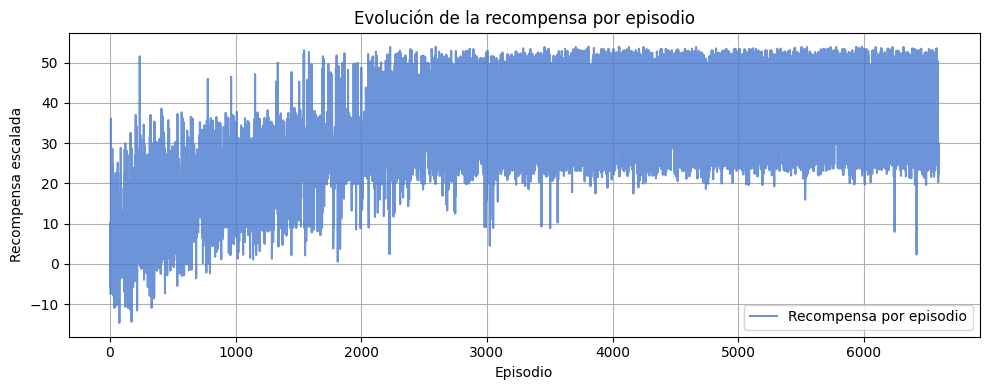

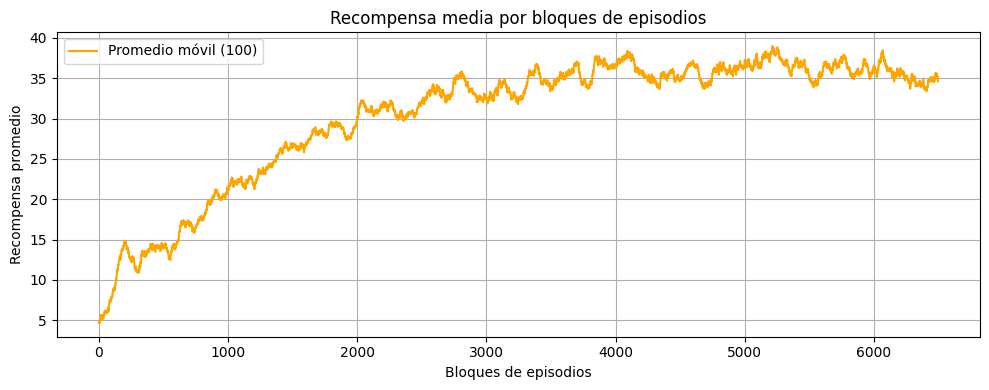

In [41]:
# -------------------------------------------------------------------------------------
# CALLBACK PERSONALIZADO PARA MONITORIZAR ENTRENAMIENTO
# -------------------------------------------------------------------------------------
class RewardLoggerCallback(BaseCallback):
    def __init__(self, log_path="acciones_episodios.csv", verbose=1):
        """
        Callback personalizado que registra recompensas y acciones tomadas en cada episodio,
        y almacena estos datos en un archivo CSV para posterior análisis.

        Args:
            log_path (str): ruta donde se guardará el CSV.
            verbose (int): nivel de detalle para la consola.
        """
        super().__init__(verbose)

        # Buffers de recompensas y acciones.
        self.episode_rewards = []               # Lista de recompensas acumuladas por episodio.
        self.episode_actions = []               # Lista de secuencias de acciones tomadas por episodio.
        self.current_episode_actions = []       # Acciones actuales tomadas hasta el momento.
        self.episode_count = 0                  # Contador de episodios completados.

        self.log_path = log_path                # Ruta del archivo CSV.

        # Inicializar archivo CSV con encabezados.
        with open(self.log_path, "w", newline="") as f:
            writer = csv.writer(f)
            writer.writerow(["episode", "timesteps", "reward", "num_actions", "actions_plus_1"])

    def _on_training_start(self):
        """
        Se ejecuta automáticamente al inicio del entrenamiento.
        Reinicia el buffer de acciones del episodio actual.
        """
        self.current_episode_actions = []

    def _on_step(self) -> bool:
        """
        Se ejecuta en cada paso del entorno durante el entrenamiento.
        Almacena las acciones tomadas y registra información si un episodio ha terminado.
        """
        infos = self.locals["infos"]                    # Diccionario con info adicional del entorno.
        actions = self.locals["actions"]                # Acciones elegidas en este paso.

        self.current_episode_actions.append(int(actions[0]) + 1)  # +1 para mapear a semanas reales

        info = infos[0]  # Se selecciona un entorno arbitrario (típicamente el primero).
        if "episode" in info:
            reward = info["episode"]["r"]
            acciones = self.current_episode_actions.copy()

            self.episode_rewards.append(reward)
            self.episode_actions.append(acciones)

            with open(self.log_path, "a", newline="") as f:
                writer = csv.writer(f)
                writer.writerow([self.episode_count, self.num_timesteps, reward, len(acciones), str(acciones)])

            if self.num_timesteps % 500 == 0:
                print(f"\nEpisodio {self.episode_count} en paso {self.num_timesteps}")
                print(f"  Recompensa: {reward:.4f}   Acciones ({len(acciones)}): {acciones}")

            self.episode_count += 1
            self.current_episode_actions = []

        return True

    def plot_rewards(self):
        """
        Dibuja un gráfico con la recompensa obtenida en cada episodio individual.
        """
        plt.figure(figsize=(10, 4))
        plt.plot(self.episode_rewards, label="Recompensa por episodio", alpha=0.8)
        plt.xlabel("Episodio")
        plt.ylabel("Recompensa escalada")
        plt.title("Evolución de la recompensa por episodio")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

    def plot_avg_rewards(self, episodes_interval=50):
        """
        Muestra la evolución de la recompensa promedio cada N episodios.
        Permite observar tendencias más estables.

        Args:
            episodes_interval (int): tamaño de ventana para el promedio móvil.
        """
        if len(self.episode_rewards) < episodes_interval:
            print("No hay suficientes episodios para el promedio.")
            return

        rolling = [
            np.mean(self.episode_rewards[i:i + episodes_interval])
            for i in range(len(self.episode_rewards) - episodes_interval + 1)
        ]

        plt.figure(figsize=(10, 4))
        plt.plot(rolling, label=f"Promedio móvil ({episodes_interval})", color="orange")
        plt.xlabel("Bloques de episodios")
        plt.ylabel("Recompensa promedio")
        plt.title("Recompensa media por bloques de episodios")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()


# -------------------------------------------------------------------------------------
# DEFINICIÓN DE FUNCIONES AUXILIARES PARA ENTORNOS ENMASCARADOS
# -------------------------------------------------------------------------------------

# Función auxiliar obligatoria para entornos enmascarados.
# Se llama automáticamente por MaskablePPO para obtener la máscara de acciones.
def mask_fn(env):
    return env.action_masks()


# Función de fábrica para crear entornos individuales.
# Necesaria para DummyVecEnv, que exige una función que devuelva un entorno nuevo.
def make_env():
    def _init():
        # Se crea una instancia del entorno personalizado con los parámetros por defecto.
        env = AcuiculturaEnvDiscreto(
            temperature_data=temperature,       # Datos semanales de temperatura.
            feed_rates_data=feed_rates,         # Parámetros técnicos del alimento.
            sale_prices_data=sale_prices,       # Precios de venta del pescado por semana.
            feed_prices_data=feed_prices,       # Costes semanales del alimento.
            max_weeks=None,                     # Horizonte de planificación (aleatorio).
            start_local_week=None,              # Semana de inicio (aleatorio).
            max_seeding=78,                     # Máximo de semanas de siembra posibles.
            initial_fish_weight=30,             # Peso inicial del pez (g).
            initial_population=7100,            # Número inicial de peces.
            chosen_feed_id='121'                # Tipo de alimento utilizado.
        )

        # Se aplica enmascaramiento de acciones (solo permite acciones válidas).
        env = ActionMasker(env, mask_fn)

        # Se aplica wrapper Monitor para registrar episodios y recompensas.
        return Monitor(env)

    return _init  # Devuelve la función (no el entorno ya creado).


# -------------------------------------------------------------------------------------
# CREACIÓN DEL ENTORNO VECTORIZADO
# -------------------------------------------------------------------------------------

# Se crean múltiples entornos independientes para entrenamiento paralelo.
env_list = [make_env() for _ in range(4)]

# Se combinan en un DummyVecEnv para compatibilidad con MaskablePPO.
vec_env = DummyVecEnv(env_list)

# -------------------------------------------------------------------------------------
# CONFIGURACIÓN Y ENTRENAMIENTO DEL MODELO PPO ENMASCARADO
# -------------------------------------------------------------------------------------

# Se crea el callback que guardará las métricas durante el entrenamiento.
callback_logger = RewardLoggerCallback(verbose=1)

# Se define el modelo PPO enmascarado con los hiperparámetros optimizados.
model = MaskablePPO(
    policy="MultiInputPolicy",                                          # Política capaz de procesar dict con máscaras.
    env=vec_env,                                                        # Entorno vectorizado con lógica y wrappers.
    verbose=1,                                                          # Verbosidad de logs durante entrenamiento.
    policy_kwargs=dict(net_arch=list(study.best_params['net_arch'])),   # Arquitectura de la red neuronal (2 capas de 128 neuronas).
    learning_rate=study.best_params['learning_rate'],                   # Tasa de aprendizaje del optimizador.
    n_steps=study.best_params['n_steps'],                               # Número de pasos por entorno antes de actualizar.
    batch_size=study.best_params['batch_size'],                         # Tamaño del minibatch para cada actualización.
    gamma=study.best_params['gamma'],                                   # Factor de descuento para recompensas futuras.
    gae_lambda=study.best_params['gae_lambda'],                         # Parámetro lambda para GAE.
    clip_range=study.best_params['clip_range'],                         # Límite para evitar updates muy grandes.
    ent_coef=study.best_params['ent_coef'],                             # Coeficiente de entropía (exploración).
    vf_coef=study.best_params['vf_coef'],                               # Peso de la pérdida del crítico (estimador de valor).
    max_grad_norm=100                                                   # Clipping de gradientes para evitar explosiones.
)



# Se entrena el modelo durante 500k timesteps.
# El callback se encarga de guardar métricas útiles durante el proceso.
model.learn(total_timesteps=100_000, callback=[callback_logger])

# -------------------------------------------------------------------------------------
# GUARDADO DEL MODELO ENTRENADO Y VISUALIZACIÓN DE RESULTADOS
# -------------------------------------------------------------------------------------

# Se guarda el modelo entrenado en disco.
model.save("modelo_ppo_masked")
print("Modelo guardado como modelo_ppo_masked.zip")

# Visualización de las recompensas episodio a episodio.
callback_logger.plot_rewards()

# Visualización del promedio de recompensas en bloques de episodios.
callback_logger.plot_avg_rewards(episodes_interval=100)

# **Test del modelo**

En en esta parte se pone a prueba el modelo entrenado para un episodio relativo a un horizonte de planificación. En este caso se incorpora un bucle de simulación donde para un horizonte de planificación especificado (variable `max_weeks`) se pone a prueba cual sería la planificación otorgada por el modelo empezando en cada una de las semanas del primer año (52 semanas). 

En este caso ha de notarse que la política del agente ya no es estocástica como en el entrenamiento, sino determinista ya que se quieren escoger las mejores acciones (i.e. las que tienen mayor probabilidad).

Por otro lado, este código aporta un heatmap visual donde para cada una de estas semanas probadas se muestra la planificación para cada step, donde los colores más oscuros se refieren a una siembra de un lote durante un horizonte largo. 


[Semana de inicio: 1] Recompensa total: 43815.72
Acciones elegidas: [np.int64(17), np.int64(78), np.int64(26), np.int64(78), np.int64(9)]
Horizonte cubierto: 208 semanas

[Semana de inicio: 2] Recompensa total: 48428.40
Acciones elegidas: [np.int64(17), np.int64(78), np.int64(26), np.int64(78), np.int64(9)]
Horizonte cubierto: 208 semanas

[Semana de inicio: 3] Recompensa total: 48343.50
Acciones elegidas: [np.int64(17), np.int64(78), np.int64(26), np.int64(78), np.int64(9)]
Horizonte cubierto: 208 semanas

[Semana de inicio: 4] Recompensa total: 49952.35
Acciones elegidas: [np.int64(17), np.int64(78), np.int64(26), np.int64(78), np.int64(9)]
Horizonte cubierto: 208 semanas

[Semana de inicio: 5] Recompensa total: 50573.96
Acciones elegidas: [np.int64(17), np.int64(78), np.int64(26), np.int64(78), np.int64(9)]
Horizonte cubierto: 208 semanas

[Semana de inicio: 6] Recompensa total: 46158.89
Acciones elegidas: [np.int64(17), np.int64(78), np.int64(17), np.int64(78), np.int64(18)]
Horiz

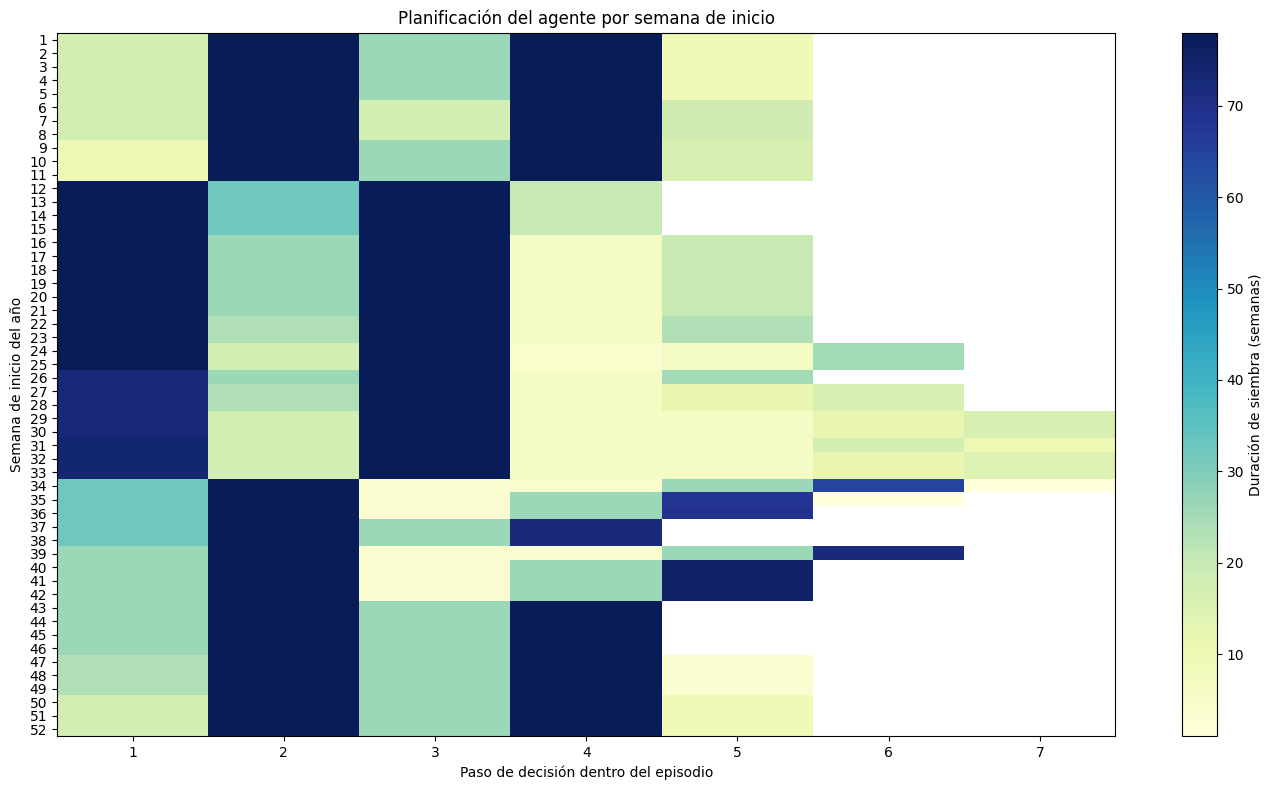

In [4]:
# -------------------------------------------------------------------------------------
# CARGA DEL MODELO ENTRENADO
# -------------------------------------------------------------------------------------
# Se carga el modelo entrenado previamente desde disco.
model = MaskablePPO.load("modelo_ppo_masked")

# Se define la función de máscara para entornos enmascarados.
def mask_fn(env):
    return env.action_masks()

# -------------------------------------------------------------------------------------
# SIMULACIÓN DEL AGENTE PARA CADA SEMANA DE INICIO (1 A 52)
# -------------------------------------------------------------------------------------

# Diccionario donde se almacenarán las acciones tomadas por semana.
acciones_por_semana = {}

# Bucle principal para ejecutar un episodio por cada semana de inicio del año.
for i in range(1, 53):
    # 1. Se crea el entorno de test.
    env_test = AcuiculturaEnvDiscreto(
        temperature_data=temperature,
        feed_rates_data=feed_rates,
        sale_prices_data=sale_prices,
        feed_prices_data=feed_prices,
        max_weeks=208,
        start_local_week=i,
        max_seeding=78,
        initial_fish_weight=30,
        initial_population=7100,
        chosen_feed_id='121'
    )
    env_test = ActionMasker(env_test, mask_fn)

    # 2. Se ejecuta la política determinista en un episodio completo.
    obs, info = env_test.reset()
    done = False
    total_reward = 0.0
    actions_taken = []

    while not done:
        action, _ = model.predict(obs, deterministic=True, action_masks=obs["action_mask"])

        # Validación para detectar errores por si acaso.
        if (action + 1) > env_test.env.remaining_weeks:
            print(f"Acción inválida: {action + 1} semanas, pero solo quedan {env_test.remaining_weeks}. Deteniendo.")
            break

        obs, reward, done, _, _ = env_test.step(action)
        total_reward += reward
        actions_taken.append(action + 1)

    # 3. Se imprime la información del episodio actual.
    print(f"\n[Semana de inicio: {i}] Recompensa total: {total_reward * 1000:.2f}")
    print(f"Acciones elegidas: {actions_taken}")
    print(f"Horizonte cubierto: {sum(actions_taken)} semanas")

    # 4. Se guarda la secuencia de acciones en el diccionario.
    acciones_por_semana[i] = actions_taken

# -------------------------------------------------------------------------------------
# CONSTRUCCIÓN Y VISUALIZACIÓN DEL HEATMAP
# -------------------------------------------------------------------------------------

# 1. Se determina el número máximo de pasos tomados en cualquier episodio.
max_len = max(len(a) for a in acciones_por_semana.values())

# 2. Se construye una matriz de tamaño (52, max_len) con valores NaN por defecto.
heatmap = np.full((52, max_len), np.nan)

# 3. Se rellena la matriz con las acciones tomadas por semana.
for semana in range(1, 53):
    acciones = acciones_por_semana[semana]
    heatmap[semana - 1, :len(acciones)] = acciones

# 4. Se genera el gráfico tipo heatmap.
plt.figure(figsize=(14, 8))
plt.imshow(heatmap, cmap="YlGnBu", aspect="auto")
plt.colorbar(label="Duración de siembra (semanas)")
plt.xlabel("Paso de decisión dentro del episodio")
plt.ylabel("Semana de inicio del año")
plt.title("Planificación del agente por semana de inicio")
plt.yticks(ticks=np.arange(52), labels=np.arange(1, 53))
plt.xticks(ticks=np.arange(max_len), labels=np.arange(1, max_len + 1))
plt.grid(False)
plt.tight_layout()
plt.show()


# **Simulación secuencial y visualización del modelo entrenado**

En esta sección se pone a prueba el modelo entrenado en un episodio completo, simulando el ciclo de planificación a partir de una semana de inicio determinada. Al igual que antes la política empleada es determinista, lo que garantiza que en cada paso se escoja la acción más probable según la política aprendida (i.e. la de mayor probabilidad sin muestreo aleatorio).

Para cada acción tomada, se simula un lote completo de engorde de peces, registrando todas las variables relevantes como peso, población, alimento consumido, costes e ingresos. Estas simulaciones se ejecutan lote a lote hasta agotar el horizonte de planificación seleccionado.

Al finalizar la simulación, se genera un conjunto de gráficos donde se visualiza la evolución temporal de cada variable, diferenciando claramente los distintos lotes mediante colores. Este enfoque permite analizar en detalle el comportamiento estratégico del agente y evaluar la coherencia y rentabilidad de sus decisiones a lo largo del tiempo.


[Ejecución modelo] Acción por lote:
  Lote 1: 73 semanas (desde semana 26)
  Lote 2: 26 semanas (desde semana 99)
  Lote 3: 78 semanas (desde semana 125)
  Lote 4: 6 semanas (desde semana 203)
  Lote 5: 25 semanas (desde semana 209)

CSV generado: simulacion_modelo.csv


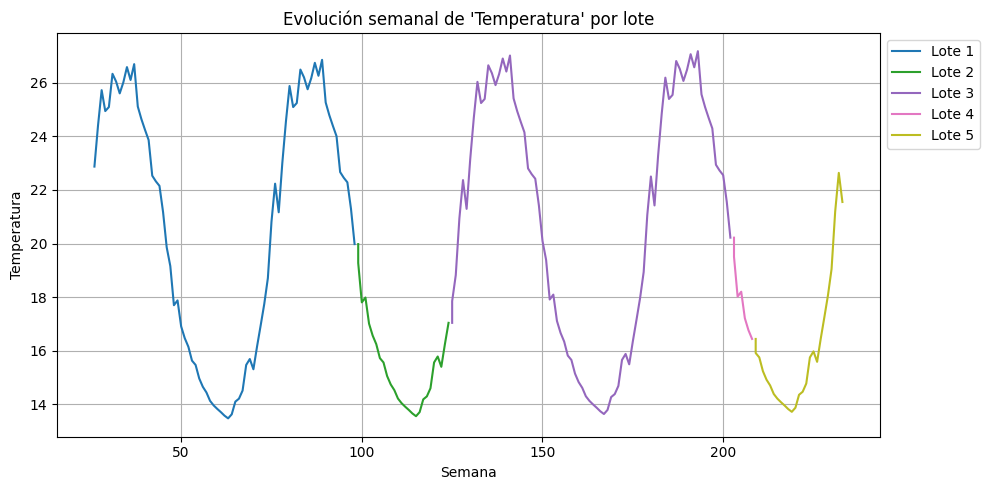

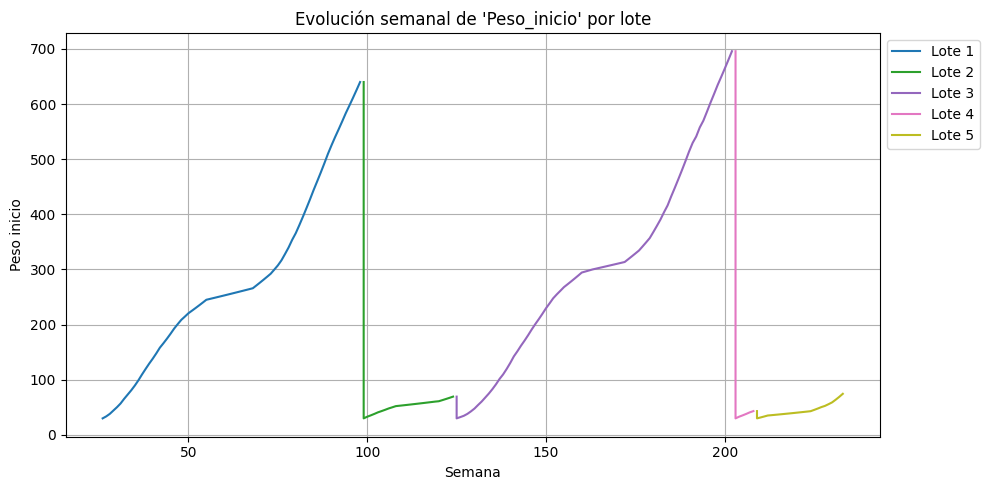

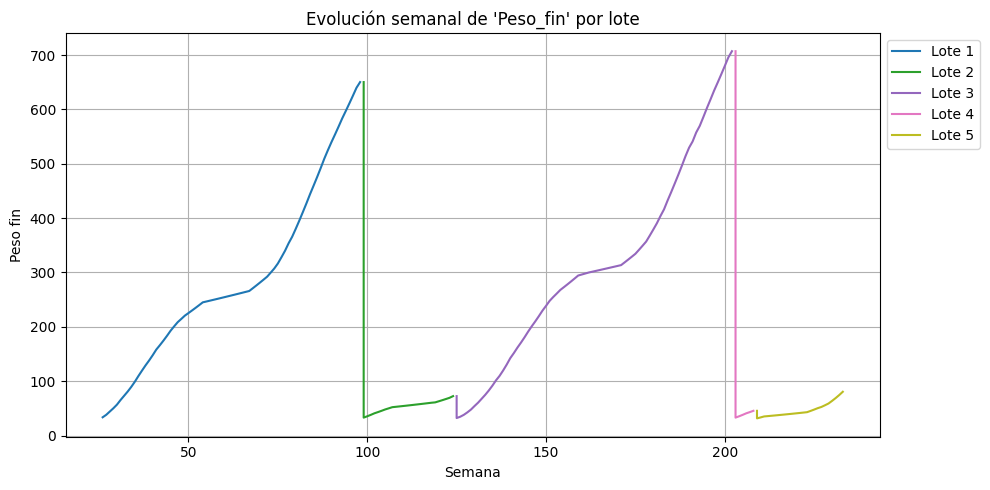

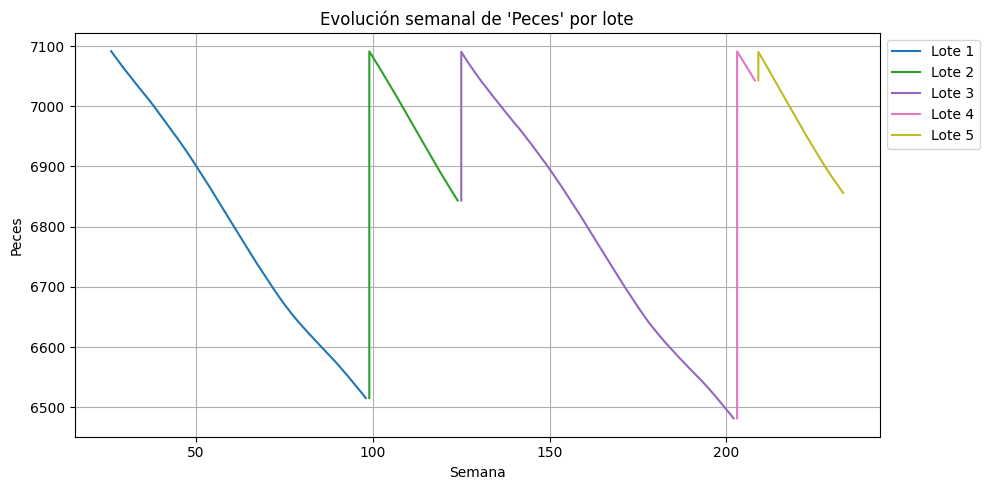

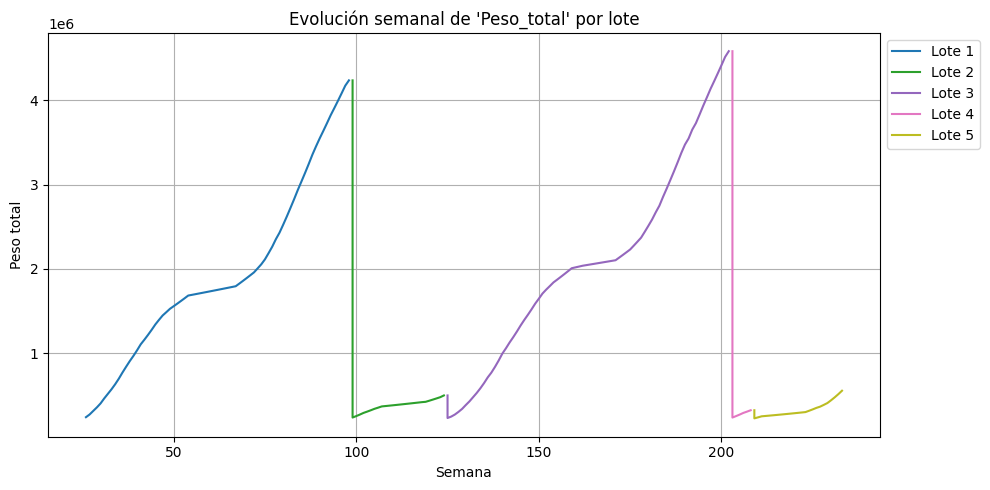

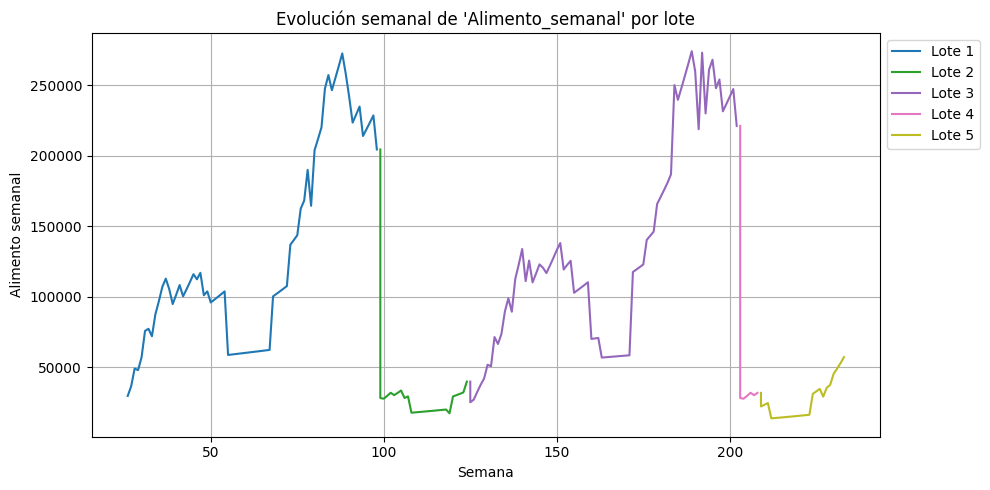

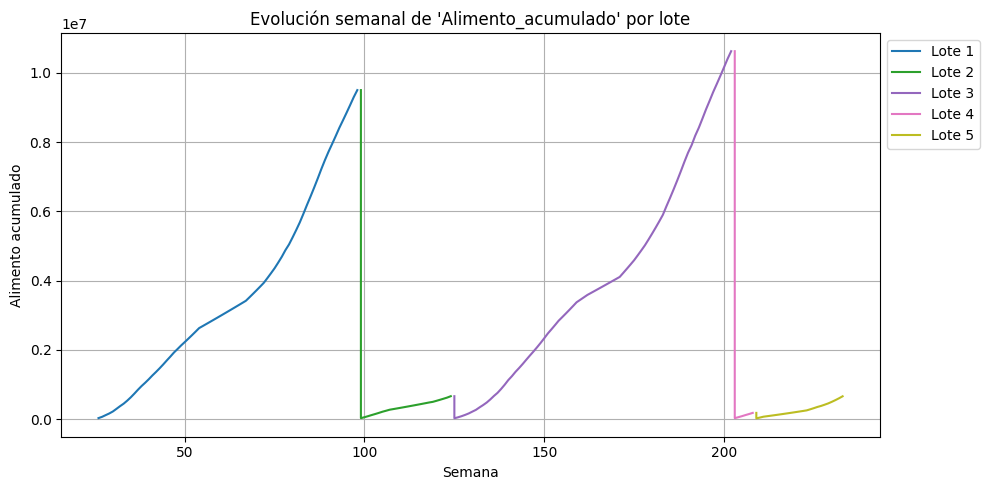

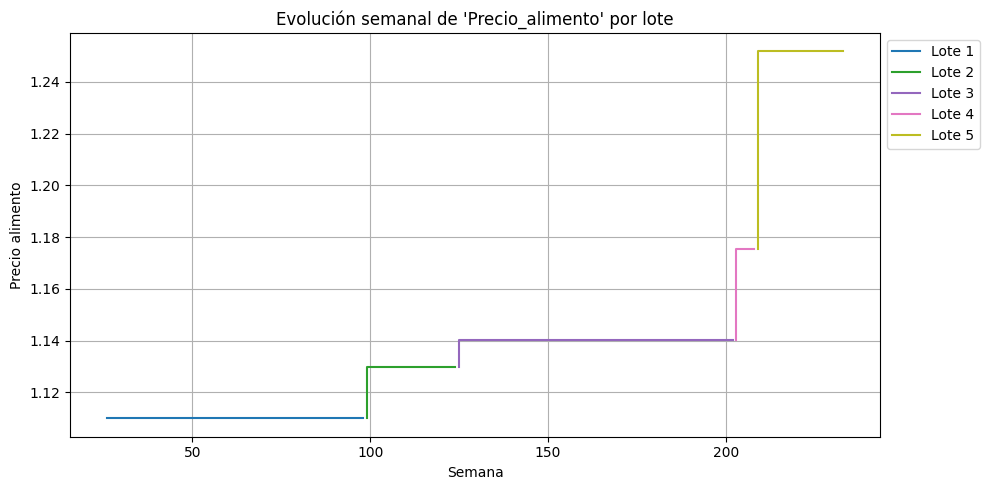

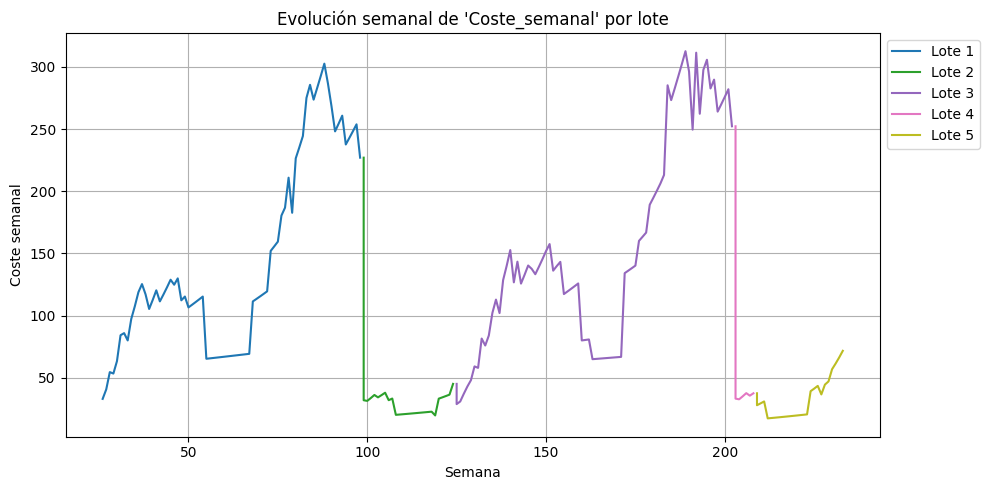

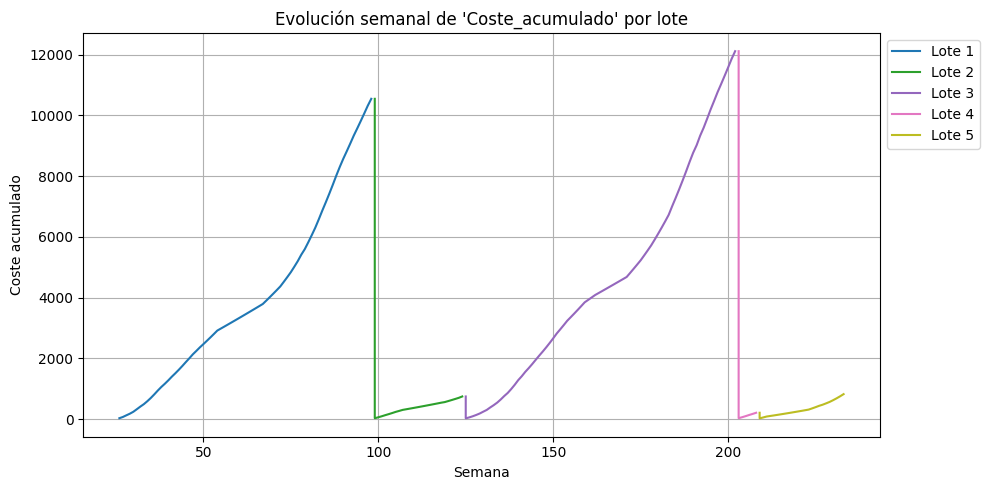

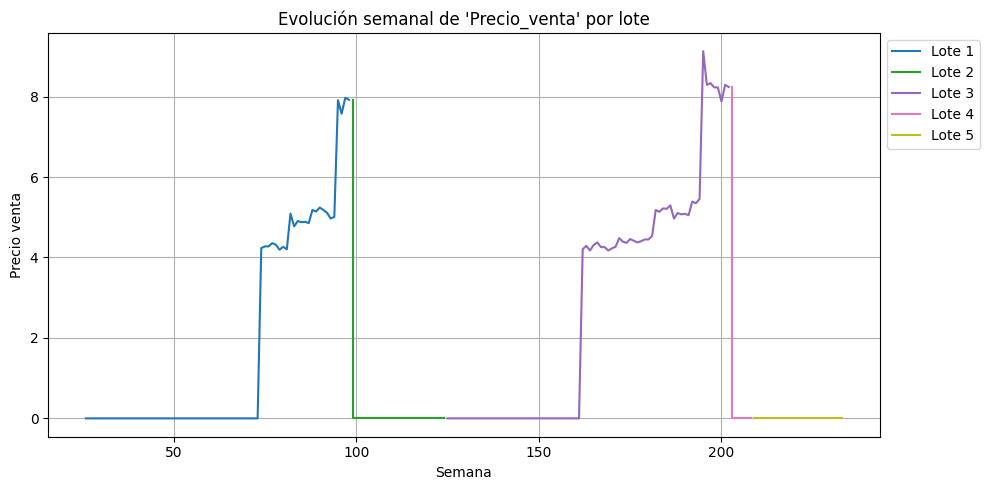

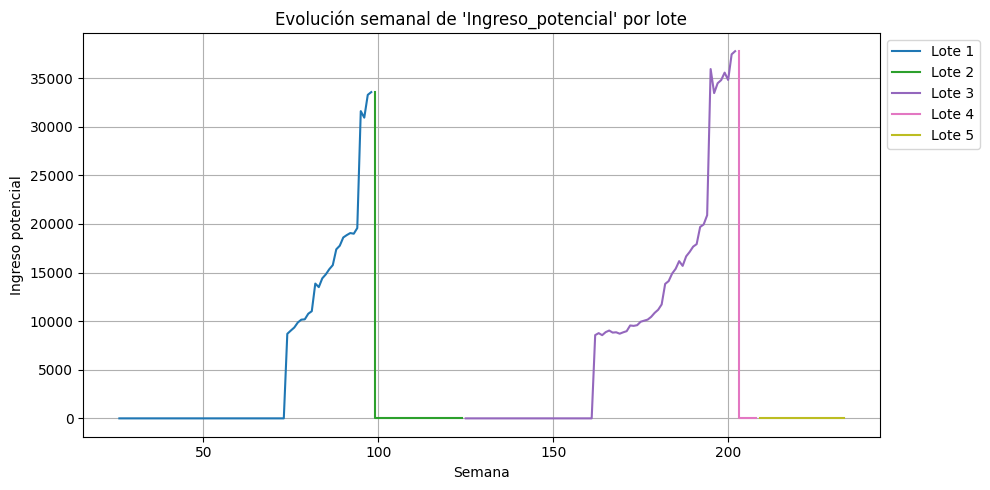

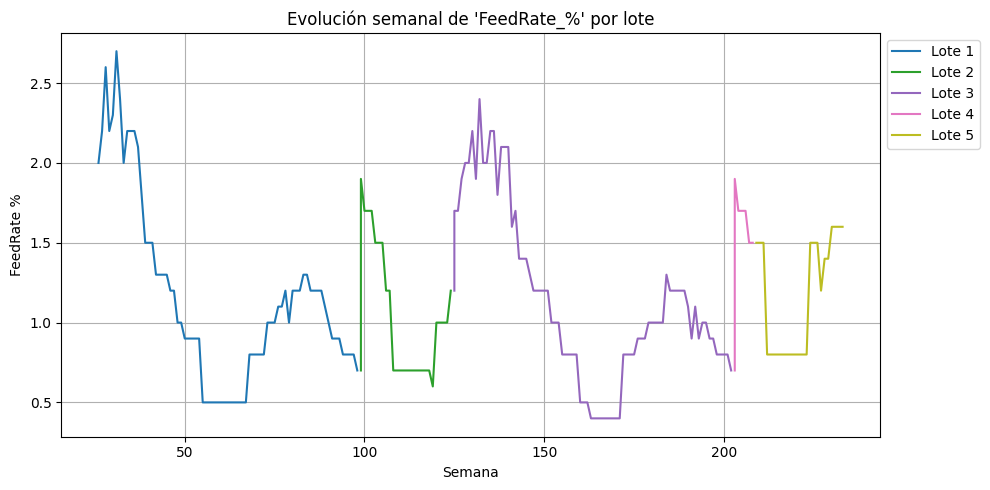

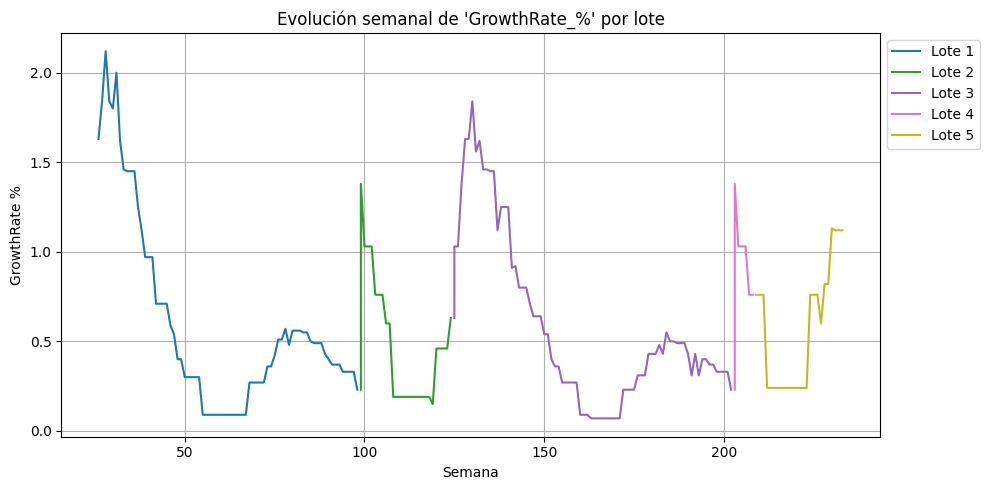

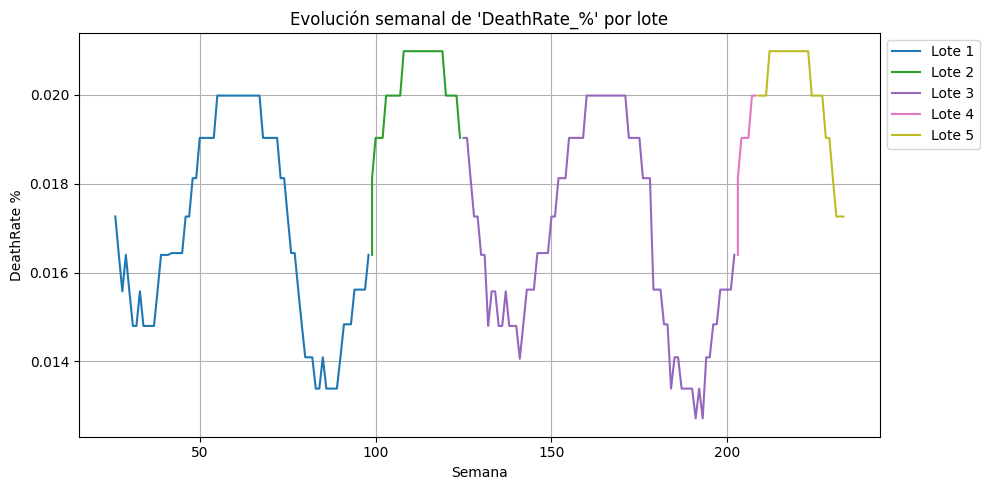

In [5]:
# -------------------------------
# Cargar modelo y entorno de test
# -------------------------------

# Se carga desde disco el modelo entrenado previamente con MaskablePPO.
model = MaskablePPO.load("modelo_ppo_masked")

# Se inicializa el entorno personalizado con los parámetros deseados para la simulación de test.
env_test = AcuiculturaEnvDiscreto(
    temperature_data=temperature,           # Datos semanales de temperatura.
    feed_rates_data=feed_rates,             # Tabla técnica del alimento.
    sale_prices_data=sale_prices,           # Precios de venta por semana y categoría.
    feed_prices_data=feed_prices,           # Coste semanal del alimento.
    max_weeks=208,                          # Horizonte total de planificación.
    start_local_week=26,                     # Semana de inicio fija.
    max_seeding=78,                         # Máximo de semanas que se pueden sembrar.
    initial_fish_weight=30,                 # Peso inicial del pez (g).
    initial_population=7100,                # Número inicial de peces.
    chosen_feed_id='121'                    # ID del alimento utilizado.
)

# --------------------------------------
# Simulación basada en acciones del PPO
# --------------------------------------
def simular_lotes_automaticamente(env, modelo):
    """
    Ejecuta el modelo PPO en modo determinista sobre el entorno, lote a lote.
    Cada lote representa una acción tomada por el agente (número de semanas de siembra).
    """
    obs, info = env.reset()                     # Se resetea el entorno y se obtiene la observación inicial.
    done = False                                # Indicador de finalización del episodio.
    current_week = env.start_local_week         # Semana natural actual.
    lote_nro = 1                                # Número de lote actual.
    sim_dfs = []                                # Lista de DataFrames con los datos por lote.

    print("\n[Ejecución modelo] Acción por lote:")

    while not done:
        action, _ = modelo.predict(obs, deterministic=True, action_masks=obs["action_mask"])
        semanas = int(action) + 1               # Acción (0–77) se convierte en semanas (1–78).

        print(f"  Lote {lote_nro}: {semanas} semanas (desde semana {current_week})")

        # Se simula el lote con los parámetros actuales y se almacena el resultado.
        df_lote = simular_lote(
            start_week_natural=current_week,
            num_sowing_weeks=semanas,
            initial_weight=30.0,
            initial_population=7100,
            lote_nro=lote_nro
        )

        sim_dfs.append(df_lote)                 # Se acumulan los resultados del lote.

        obs, reward, done, truncated, info = env.step(action)  # Se avanza en el entorno.
        current_week += semanas                 # Se actualiza la semana natural.
        lote_nro += 1                           # Se incrementa el número de lote.

    # Se unen todos los DataFrames generados por cada lote en uno solo.
    df_final = pd.concat(sim_dfs, ignore_index=True)
    return df_final


# -------------------------------
# Función de simulación del lote
# -------------------------------
def simular_lote(start_week_natural, num_sowing_weeks, initial_weight, initial_population, lote_nro):
    """
    Simula el crecimiento de peces para un lote específico.
    Calcula semana a semana el peso, población, alimento, ingresos y costes.
    """
    # Se seleccionan las tasas del alimento elegido (por ID).
    chosen_feed_rates = feed_rates[feed_rates[:, 0] == '121']

    # Extracción de parámetros técnicos desde la tabla.
    temp_min = chosen_feed_rates[:, 1].astype(float)
    temp_max = chosen_feed_rates[:, 2].astype(float)
    weight_min = chosen_feed_rates[:, 3].astype(float)
    weight_max = chosen_feed_rates[:, 4].astype(float)
    feeding_rate = chosen_feed_rates[:, 5].astype(float)
    growth_rate = chosen_feed_rates[:, 6].astype(float)
    death_rate = chosen_feed_rates[:, 7].astype(float)

    # Inicialización del estado del lote.
    fish_weight = initial_weight
    population = initial_population
    total_feed = 0.0
    total_cost = 0.0
    week = start_week_natural
    rows = []

    # Se extrae el precio del alimento al inicio del lote (como se hace en compute_reward).
    feed_row = feed_prices[feed_prices[:, 0] == start_week_natural]
    feed_price = float(feed_row[0, 1]) if len(feed_row) > 0 else 0.0

    for i in range(num_sowing_weeks):
        if week >= len(temperature):
            break

        # Se extrae la temperatura de la semana correspondiente.
        temp_val = float(temperature[week - 1, 1])

        # Se busca la fila válida cuyas condiciones coincidan con peso y temperatura actuales.
        mask = (
            (temp_min <= temp_val) & (temp_val <= temp_max) &
            (weight_min <= fish_weight) & (fish_weight <= weight_max)
        )

        if np.any(mask):
            idx = np.nonzero(mask)[0][0]
            frate = (feeding_rate[idx] / 100.0) * 7
            grate = (1 + growth_rate[idx] / 100.0) ** 7
            drate = (1 - death_rate[idx] / 100.0) ** 7
            fr_val = feeding_rate[idx]
            gr_val = growth_rate[idx]
            dr_val = death_rate[idx]
        else:
            frate, grate, drate = 0.0, 1.0, 1.0
            fr_val = gr_val = dr_val = 0.0

        weight_start = fish_weight
        pop_start = population

        # Se calcula el alimento consumido y se actualizan los acumuladores.
        weekly_feed = frate * weight_start * pop_start
        total_feed += weekly_feed

        # Evolución de peso y población.
        fish_weight *= grate
        population *= drate

        # Coste del alimento para esta semana.
        cost_week = (weekly_feed / 1000.0) * feed_price
        total_cost += cost_week

        # Ingreso potencial en función del peso final y el precio de venta.
        if fish_weight < 300:
            price = 0
            ingreso = 0
        else:
            col_idx = 1 if fish_weight < 400 else (2 if fish_weight < 600 else 3)
            venta_row = sale_prices[sale_prices[:, 0] == week]
            price = float(venta_row[0, col_idx]) if len(venta_row) > 0 else 0.0
            ingreso = population * (fish_weight / 1000.0) * price

        peso_total = population * fish_weight

        # Se almacena la información semanal.
        rows.append({
            "Lote": lote_nro,
            "Semana": week,
            "Temperatura": temp_val,
            "Peso_inicio": weight_start,
            "Peso_fin": fish_weight,
            "Peces": population,
            "Peso_total": peso_total,
            "Alimento_semanal": weekly_feed,
            "Alimento_acumulado": total_feed,
            "Precio_alimento": feed_price,
            "Coste_semanal": cost_week,
            "Coste_acumulado": total_cost,
            "Precio_venta": price,
            "Ingreso_potencial": ingreso,
            "FeedRate_%": fr_val,
            "GrowthRate_%": gr_val,
            "DeathRate_%": dr_val
        })

        # Si la población se extingue, se detiene anticipadamente la simulación.
        if population <= 0:
            print(f"Población extinguida en lote {lote_nro}. Fin anticipado.")
            break

        week += 1

    return pd.DataFrame(rows)


# -----------------------------------
# Ejecutar simulación automática
# -----------------------------------
df_resultado = simular_lotes_automaticamente(env_test, model)

# Se exporta el resultado a CSV para posterior análisis o visualización externa.
csv_name = "simulacion_modelo.csv"
df_resultado.to_csv(csv_name, index=False)
print(f"\nCSV generado: {csv_name}")


# --------------------------------------------
# Gráficos de variables unidos por transición
# -------------------------------------------

# Se identifican todas las variables numéricas a graficar, excluyendo identificadores.
variables_a_graficar = [col for col in df_resultado.columns if col not in ["Semana", "Lote"]]

# Se crea una paleta de colores para distinguir claramente los distintos lotes.
lotes_unicos = sorted(df_resultado["Lote"].unique())
cmap = plt.colormaps['tab10']
colores = [cmap(i / len(lotes_unicos)) for i in range(len(lotes_unicos))]

# Se define el estilo visual de los gráficos.
plt.style.use("seaborn-v0_8-muted")

# Se genera un gráfico por cada variable incluida en el resultado.
for var in variables_a_graficar:
    plt.figure(figsize=(10, 5))

    for i, lote in enumerate(lotes_unicos):
        df_lote = df_resultado[df_resultado["Lote"] == lote]

        # Para crear continuidad entre lotes, se copia el último punto del lote anterior.
        if i > 0:
            df_prev = df_resultado[df_resultado["Lote"] == lotes_unicos[i - 1]]
            last_row = df_prev.iloc[[-1]].copy()
            last_row["Semana"] = df_lote.iloc[0]["Semana"]
            df_lote = pd.concat([last_row, df_lote], ignore_index=True)

        # Se dibuja la serie para el lote actual con su color correspondiente.
        plt.plot(df_lote["Semana"], df_lote[var], label=f"Lote {lote}", color=colores[i])

    # Títulos y estilo general del gráfico.
    plt.title(f"Evolución semanal de '{var}' por lote")
    plt.xlabel("Semana")
    plt.ylabel(var.replace("_", " "))
    plt.grid(True)

    # La leyenda se posiciona fuera del gráfico para mayor claridad.
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.tight_layout()
    plt.show()

# **Visualización estratégica de lotes productivos (sin pérdidas)**
En esta sección se realiza una representación visual depurada que considera únicamente aquellos lotes capaces de llevar al pez a un peso vendible (≥300g). Este umbral permite descartar los llamados minilotes, cuya utilidad en la planificación es meramente informativa (indican periodos sin siembra efectiva para evitar costes sin retorno).

El resultado es una serie de gráficos claros y centrados exclusivamente en los periodos de siembra económicamente rentables, facilitando así el análisis estratégico de los ciclos largos planificados por el agente y mejorando la comprensión de la política aprendida en situaciones realistas de producción.



[Ejecución modelo] Acción por lote:
  Lote 1: 73 semanas (desde semana 26)
  Lote 2: 26 semanas (desde semana 99)
  Lote 3: 78 semanas (desde semana 125)
  Lote 4: 6 semanas (desde semana 203)
  Lote 5: 25 semanas (desde semana 209)

CSV generado: simulacion_modelo.csv

Lotes rentables (sin pérdidas):
 Lote  Recompensa_neta
    1     23011.402239
    3     25649.792348

Recompensa total acumulada (solo lotes rentables): 48661.19 €


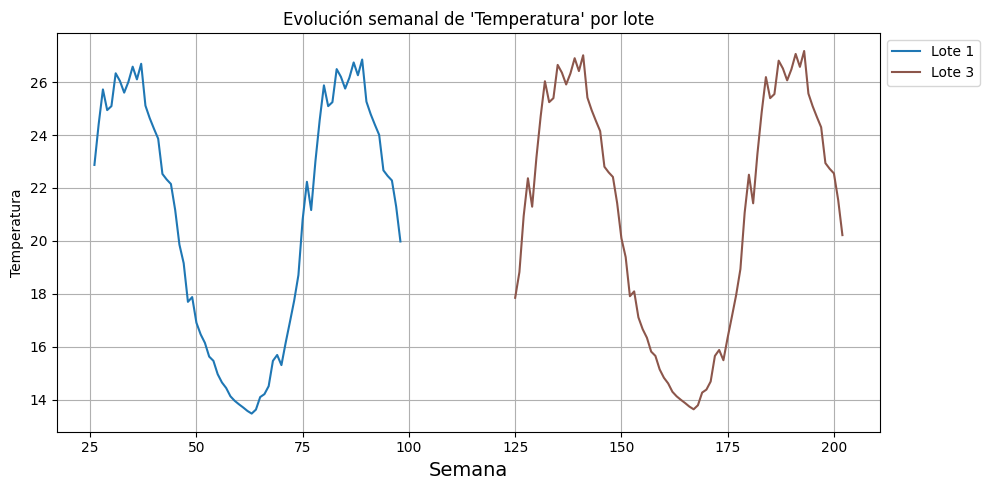

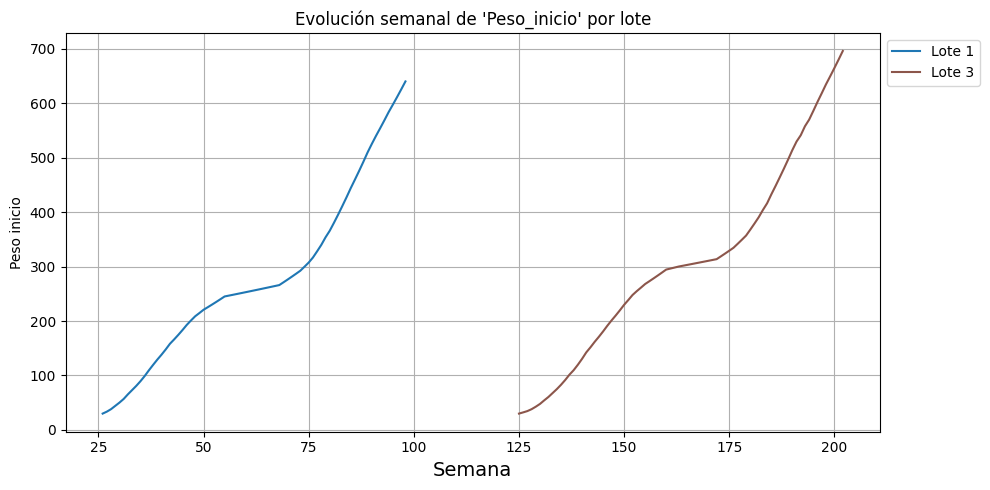

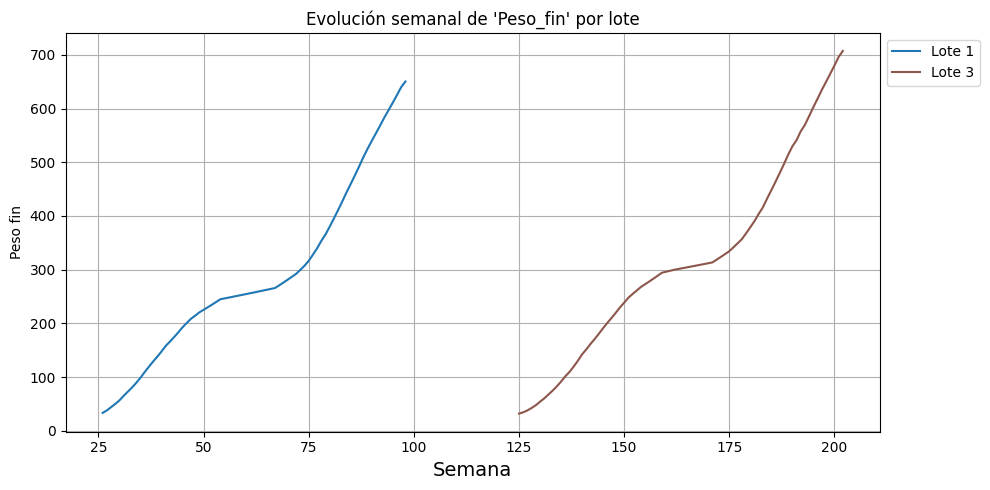

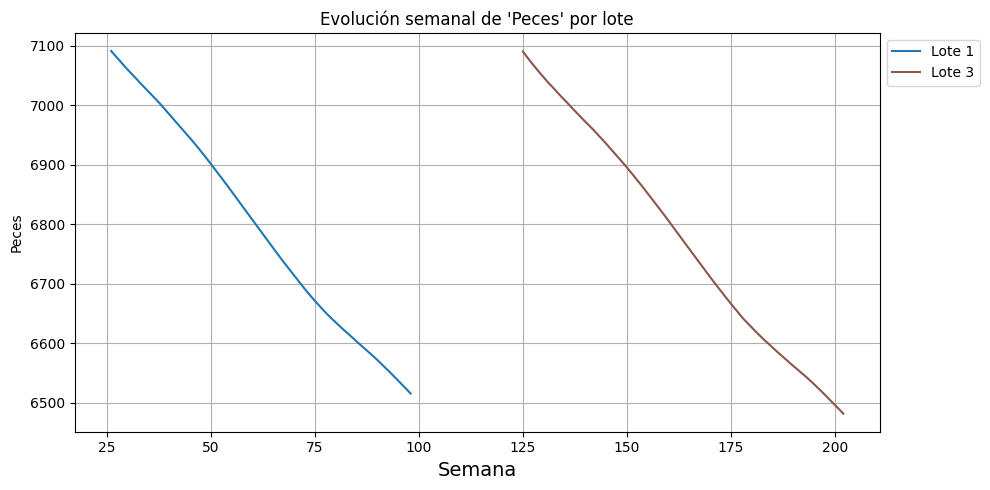

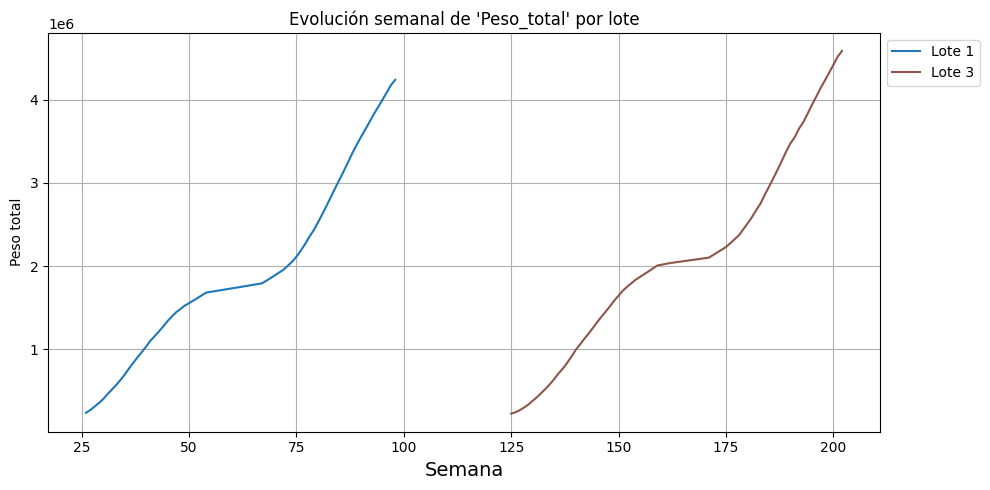

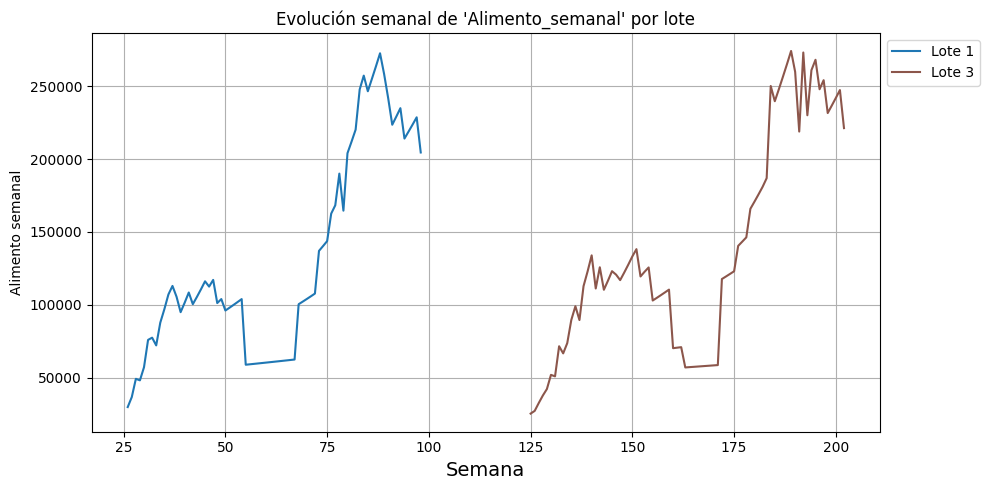

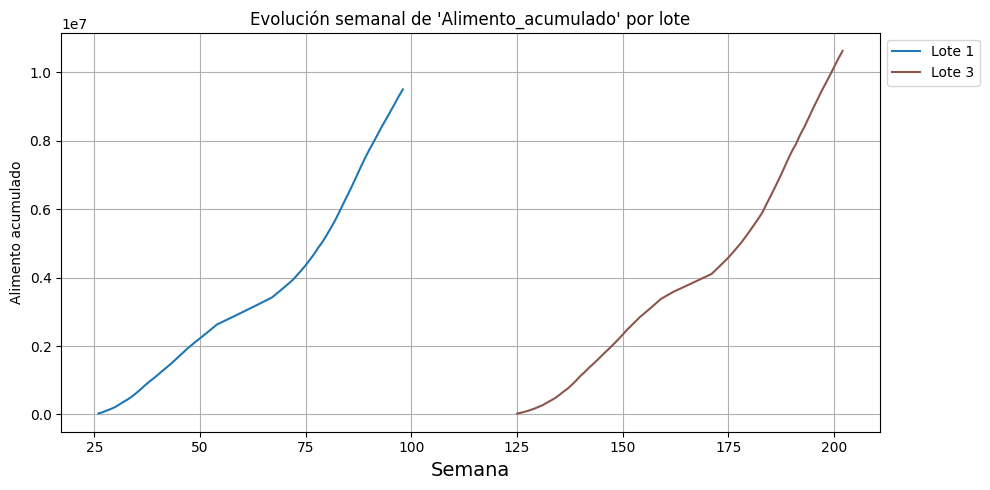

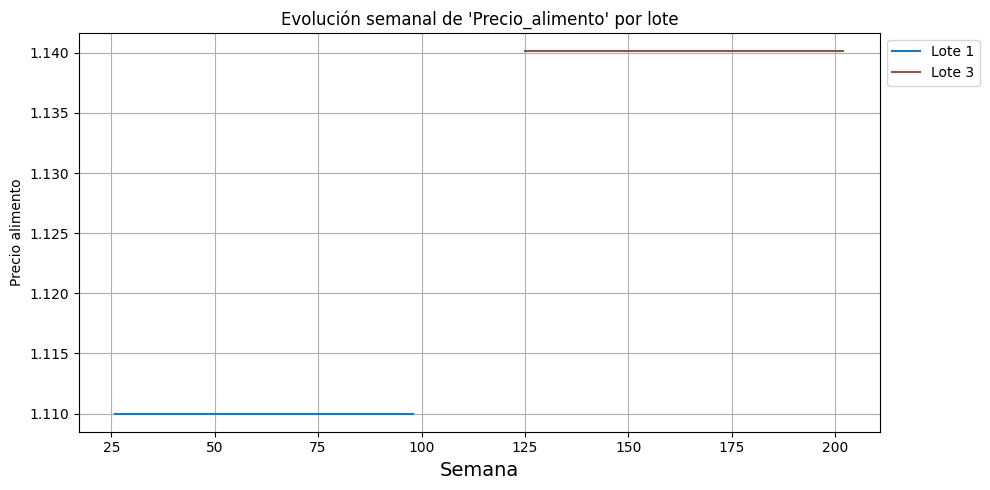

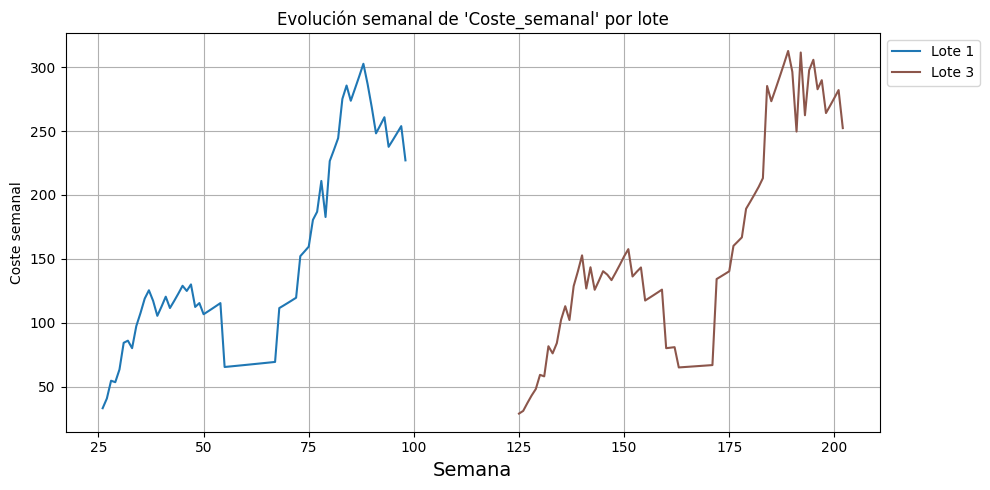

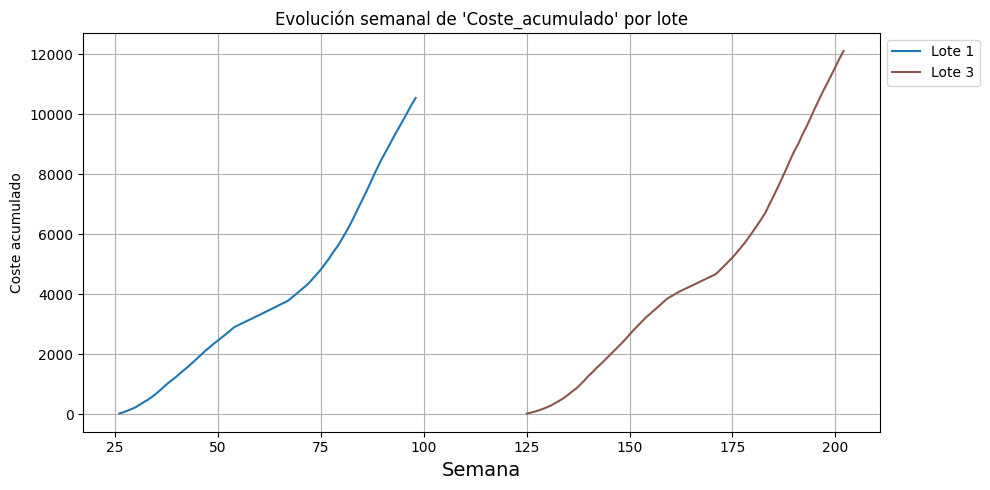

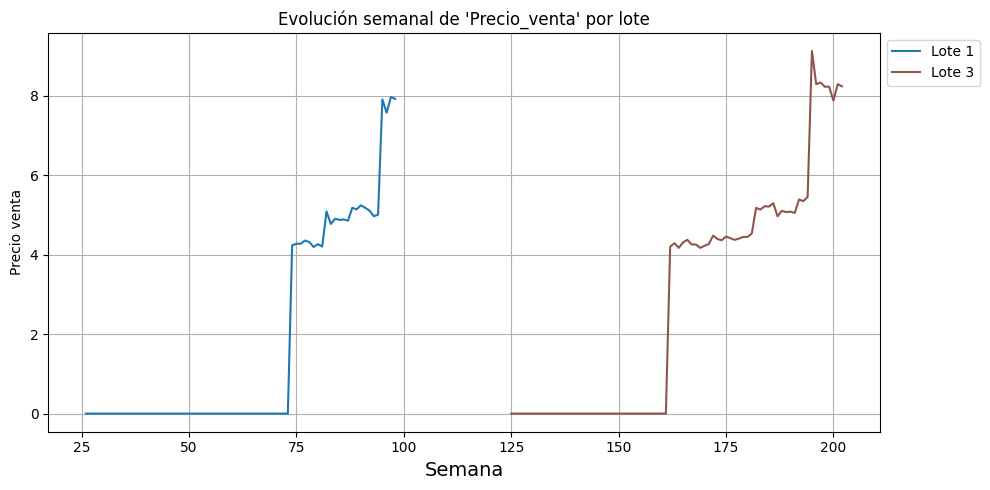

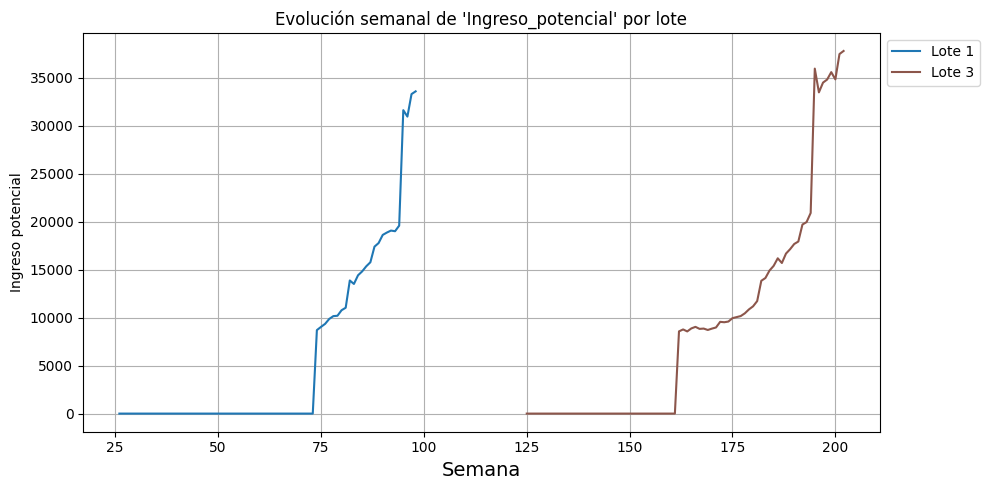

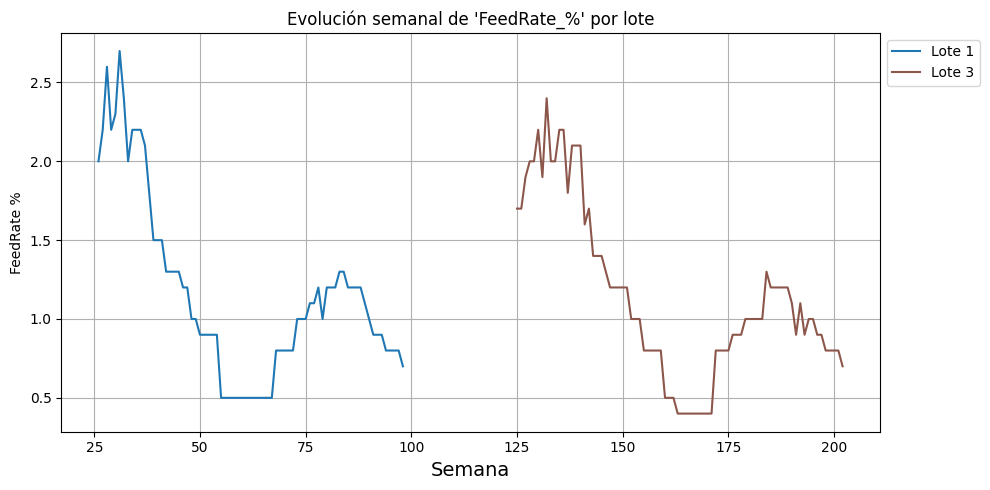

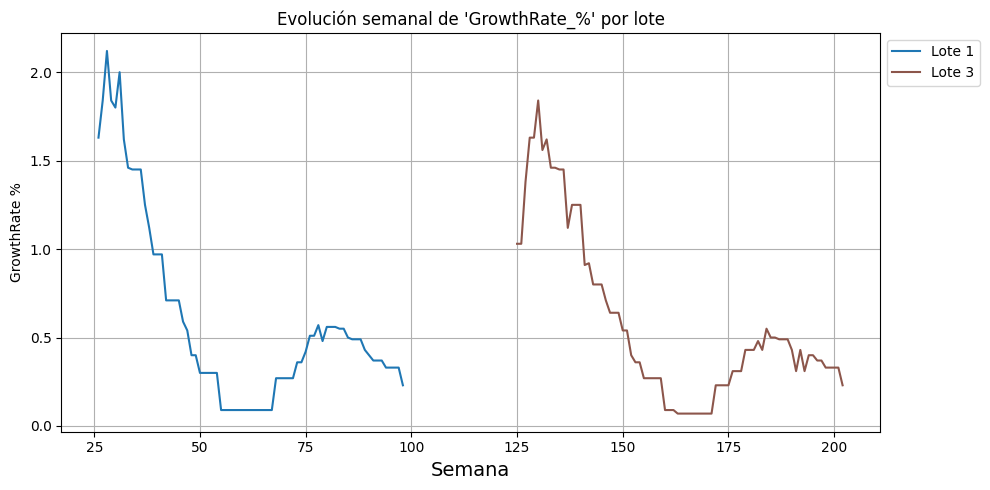

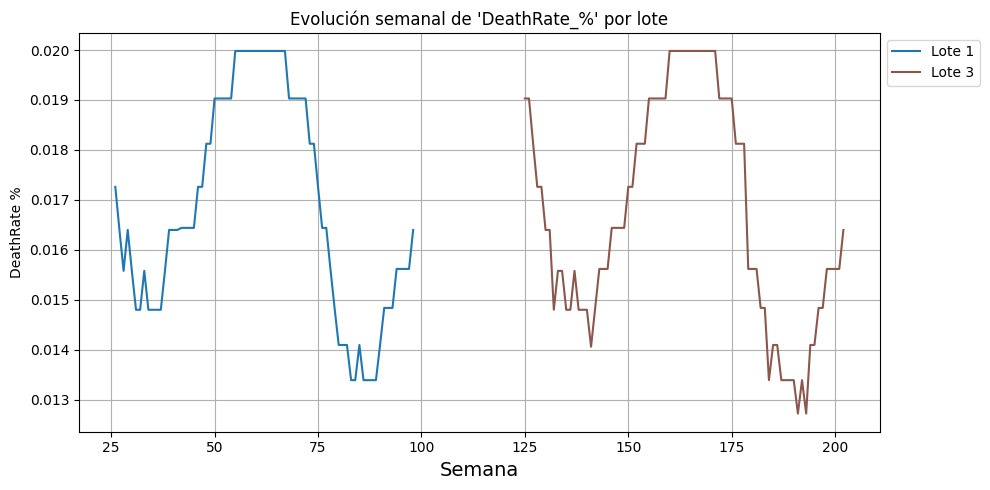

In [6]:
# -----------------------------------
# Ejecutar simulación automática
# -----------------------------------
df_resultado = simular_lotes_automaticamente(env_test, model)

# Se exporta el resultado a CSV para posterior análisis o visualización externa.
csv_name = "simulacion_modelo.csv"
df_resultado.to_csv(csv_name, index=False)
print(f"\nCSV generado: {csv_name}")

# -------------------------------------------------------------------------------------
# ANÁLISIS ESTRATÉGICO DE LOTES PRODUCTIVOS (SIN PÉRDIDAS ECONÓMICAS)
# -------------------------------------------------------------------------------------

# 1. Se agrupan los datos por lote para obtener el ingreso y coste final de cada lote.
df_final_lotes = df_resultado.groupby("Lote").agg({
    "Ingreso_potencial": "last",         # Ingreso total acumulado del lote.
    "Coste_acumulado": "last"            # Coste total acumulado del lote.
}).reset_index()

# 2. Se calcula la recompensa neta del lote como ingreso - coste.
df_final_lotes["Recompensa_neta"] = df_final_lotes["Ingreso_potencial"] - df_final_lotes["Coste_acumulado"]

# 3. Se filtran únicamente los lotes que generaron beneficio económico (recompensa ≥ 0).
lotes_rentables = df_final_lotes[df_final_lotes["Recompensa_neta"] >= 0]

# 4. Se imprime el listado de lotes sin pérdidas junto a su recompensa individual.
print("\nLotes rentables (sin pérdidas):")
print(lotes_rentables[["Lote", "Recompensa_neta"]].to_string(index=False))

# 5. Se calcula la suma total de recompensas netas obtenidas solo por los lotes rentables.
recompensa_total_sin_perdidas = lotes_rentables["Recompensa_neta"].sum()

# 6. Se imprime el beneficio total acumulado de los lotes económicamente viables.
print(f"\nRecompensa total acumulada (solo lotes rentables): {recompensa_total_sin_perdidas:.2f} €")


# -----------------------
# Gráficos de variables 
# -----------------------

# Se identifican las variables numéricas a graficar, excluyendo identificadores.
variables_a_graficar = [col for col in df_resultado.columns if col not in ["Semana", "Lote"]]

# Se calcula el peso final promedio alcanzado por lote.
peso_final_por_lote = df_resultado.groupby("Lote")["Peso_fin"].last()

# Se seleccionan los lotes con peso final igual o superior a 300g (umbral de rentabilidad).
lotes_filtrados = peso_final_por_lote[peso_final_por_lote >= 300].index.tolist()

# Paleta de colores proporcional al número de lotes válidos.
cmap = plt.colormaps['tab10']
colores = [cmap(i / len(lotes_filtrados)) for i in range(len(lotes_filtrados))]

# Estilo visual para las figuras.
plt.style.use("seaborn-v0_8-muted")

# Se genera un gráfico por cada variable seleccionada.
for var in variables_a_graficar:
    plt.figure(figsize=(10, 5))

    for i, lote in enumerate(lotes_filtrados):
        df_lote = df_resultado[df_resultado["Lote"] == lote]
        plt.plot(df_lote["Semana"], df_lote[var], label=f"Lote {lote}", color=colores[i])

    # Títulos y estilo del gráfico.
    plt.title(f"Evolución semanal de '{var}' por lote")
    plt.xlabel("Semana", fontsize = 14)
    plt.ylabel(var.replace("_", " "))
    plt.grid(True)

    # Leyenda colocada fuera del área de la figura.
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.tight_layout()
    plt.show()



